In [15]:
import os
from pathlib import Path

REPO_ROOT = Path(
    r"C:\Users\Elham.Ahmadi\OneDrive - Kühne Logistics University\Desktop\Paper Two\ML with Applications\Github"
)

os.chdir(REPO_ROOT)
print("Working directory set to:", Path.cwd())


Working directory set to: C:\Users\Elham.Ahmadi\OneDrive - Kühne Logistics University\Desktop\Paper Two\ML with Applications\Github


DATA_PATH: C:\Users\Elham.Ahmadi\OneDrive - Kühne Logistics University\Desktop\Paper Two\ML with Applications\Github\data\df_hourly_merged_clean.csv
=== Loading merged hourly dataset ===
Merged hourly df shape (raw): (1127653, 46)
Dropped column: Precipitation_Form_Hourly

99.9% quantile of |Delta_Arrival|: 21.00 minutes
Rows with |Delta_Arrival| > 21.00 min (set to NaN): 1059
After basic cleaning, shape: (1126594, 45)

Planned departure time converted to cyclic features (dep_sin, dep_cos).

Numeric features: ['Hour', 'Distance', 'Holidays_Hessen', 'month_sin', 'month_cos', 'dep_sin', 'dep_cos']
Categorical features: ['Year', 'Month', 'Weekday', 'Station_ID', 'Line_Original', 'Direction']
Cluster variable: Cluster_LineDay

Cluster variable: Cluster_LineDay

Temperature (hourly) extreme thresholds:
 q_low (0.05)  = 0.20 °C
 q_high (0.95) = 26.10 °C
0    1010720
1     115874
Name: T_temp_severe, dtype: int64

Wind (hourly) severe threshold (q=0.90): 6.40 m/s
0    1008454
1     118140
Nam

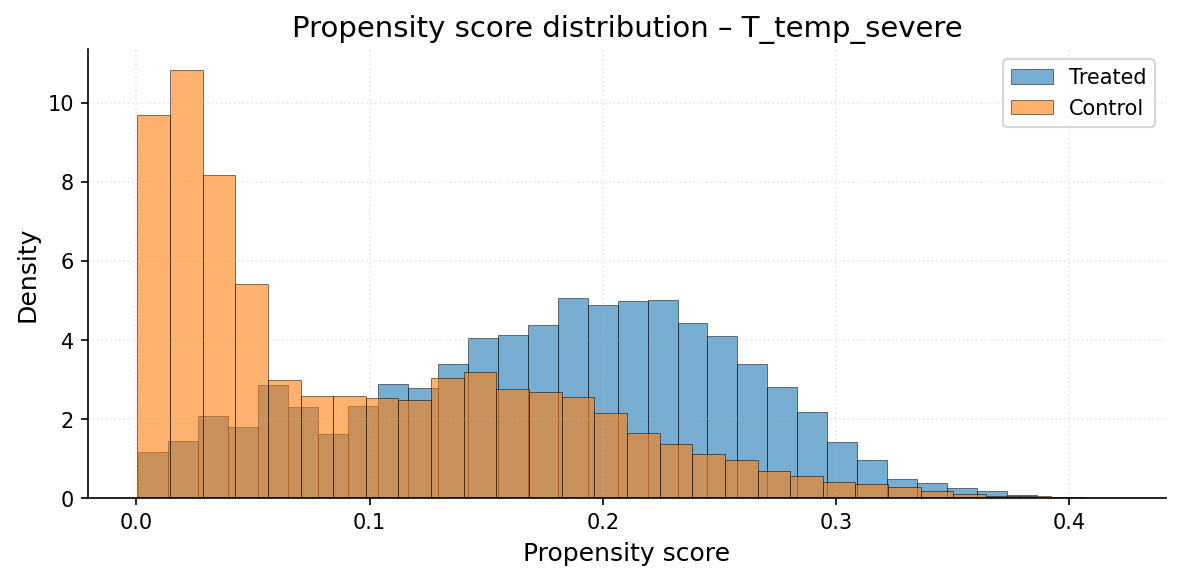


Alpha selection table (Crump-style):
    alpha   N_kept  N_treated  N_control  Crump_obj
0    0.00  1126594     115874    1010720  75.283390
1    0.01  1027130     115280     911850  21.220767
2    0.02   922621     112762     809859  15.901035
3    0.03   814865     111680     703185  12.489154
4    0.04   728800     108805     619995  10.402756
5    0.05   665612     106906     558706   9.173964
6    0.06   619906     103619     516287   8.416335
7    0.07   587296     100302     486994   7.967568
8    0.08   557116      98231     458885   7.614923
9    0.09   531421      96328     435093   7.361896
10   0.10   501980      93859     408121   7.111481
11   0.11   472719      90318     382401   6.892421
12   0.12   446128      87339     358789   6.717510
13   0.13   414978      83971     331007   6.535710
14   0.14   379819      80002     299817   6.348084
15   0.15   342190      75620     266570   6.158756
16   0.16   308049      70715     237334   5.994655
17   0.17   276009      66

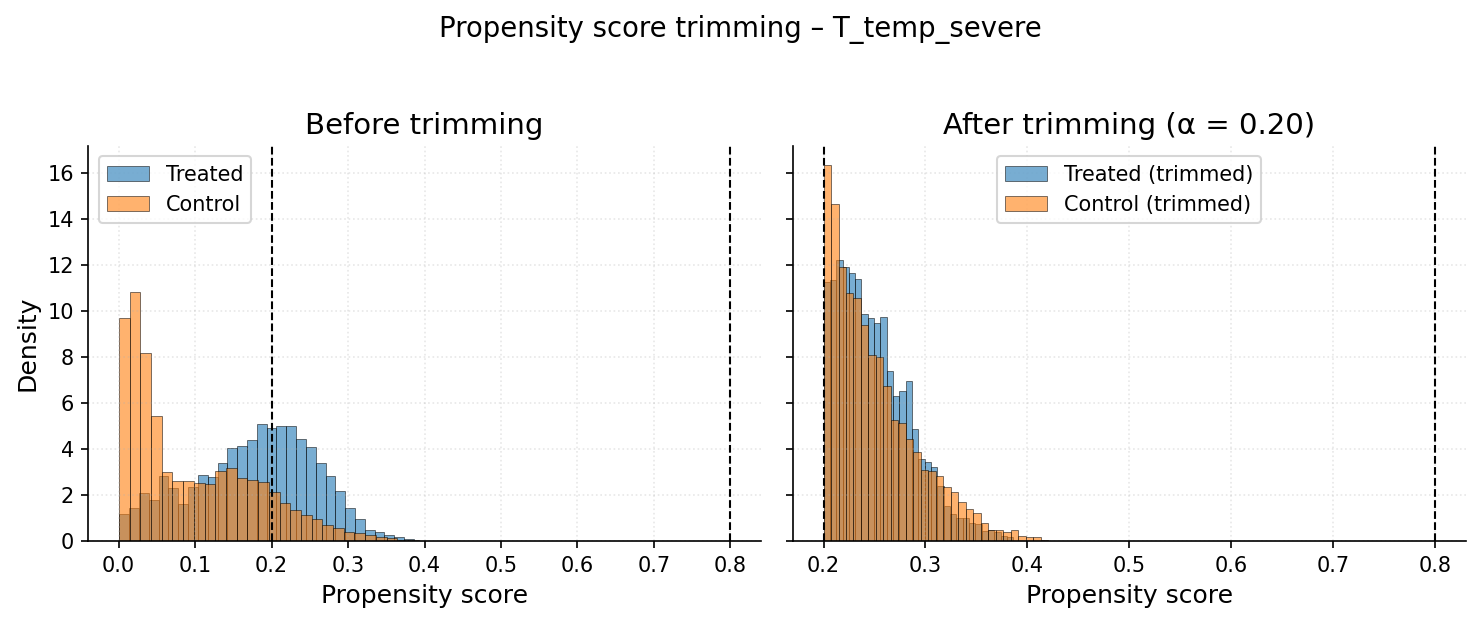

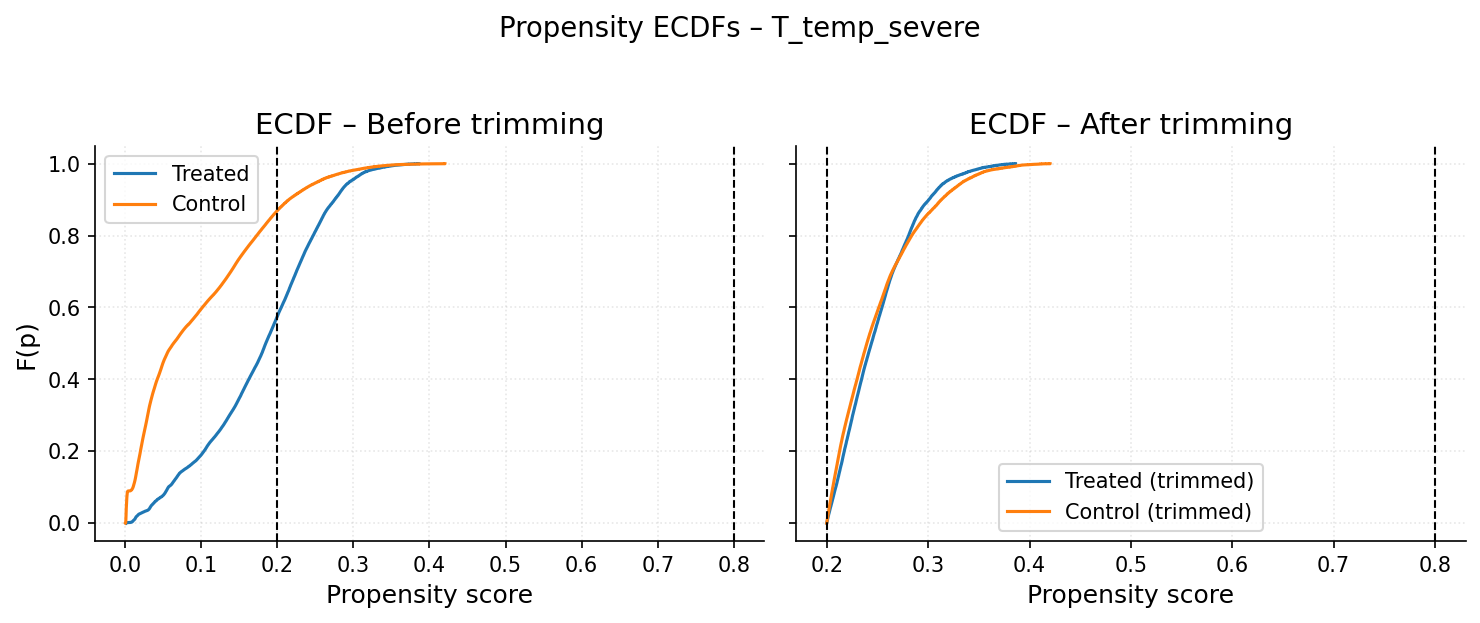


T_temp_severe: After trimming with alpha*=0.200
  N       = 181105
  Treated = 49214 | Control = 131891
  X shape = (181105, 90)

=== SMD balance (top 20 covariates by |SMD| before trimming) – T_temp_severe ===
             covariate  SMD_before  abs_SMD_before  SMD_after  abs_SMD_after
0             Month_10   -0.432294        0.432294        NaN            NaN
1              Month_1    0.368776        0.368776  -0.084635       0.084635
2              Month_4   -0.360928        0.360928        NaN            NaN
3             Month_11   -0.313538        0.313538        NaN            NaN
4              Month_5   -0.281047        0.281047        NaN            NaN
5              Month_6    0.279721        0.279721   0.038724       0.038724
6              Month_7    0.205397        0.205397   0.190140       0.190140
7              Month_3   -0.184474        0.184474        NaN            NaN
8              Month_2    0.183572        0.183572  -0.198434       0.198434
9            Year_

KeyboardInterrupt: 

In [ ]:
# Github Version
# ============================================================
# FULL PIPELINE (FROM SCRATCH) – HOURLY WEATHER → DELAY
#   (CAUSAL ML + ROBUSTNESS + CLUSTER-SE + STABILITY + GATE MT)
#
# DATA:
#   data/df_hourly_merged_clean.csv
#
# TREATMENTS (binary):
#   T_temp_severe, T_wind_severe, T_rain_severe, Snow_Any
#
# OUTCOME:
#   Delta_Arrival (minutes, + = more delay, - = early)
#
# METHODS:
#   * PLR-DML (econml.LinearDML) + CausalForestDML
#   * Crump-style overlap trimming via propensity scores
#   * Propensity histograms + ECDF (before / after trimming)
#   * SMD balance checks before/after trimming
#   * IATE scatter, GATEs by line, weekday, month, hour (Holm adjustment)
#   * OLS-based partial-R² sensitivity (Cinelli & Hazlett style inputs)
#   * Robustness value RV_zero
#   * Outcome robustness:
#       - Treated vs control delay distributions
#       - Mean, median, 5%-trimmed mean differences
#       - Winsorized mean differences (1%, 2%)
#       - Quantile treatment effects (τ = 0.5, 0.75, 0.9)
#   * Robustness frontier plot in R²-space
#   * Cluster-robust inference via manual PLR-DML (line-day clusters)
#   * Multi-seed cross-fit stability analysis (ATE per seed)

# ============================================================

import os
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

import statsmodels.api as sm
from scipy.stats import norm

from econml.dml import LinearDML, CausalForestDML

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# ============================================================
# STEP 0) OUTPUTS + GLOBAL STYLE
# ============================================================

OUTPUT_DIR = Path("outputs")
FIG_DIR = OUTPUT_DIR / "figures"
TAB_DIR = OUTPUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

SAVE_FIGS = True
SAVE_TABLES = True

plt.rcParams.update({
    "figure.figsize": (8, 4),
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": ":",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


def _safe_name(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", "_", s.strip())
    s = re.sub(r"[^a-zA-Z0-9_\-\.]+", "", s)
    return s[:180] if len(s) > 180 else s


def save_fig(fig, filename: str, subdir: str = None):
    if not SAVE_FIGS:
        return None
    out_dir = FIG_DIR if subdir is None else (FIG_DIR / subdir)
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / filename
    fig.savefig(path, bbox_inches="tight")
    return path


def save_table(df: pd.DataFrame, name: str, to_latex: bool = True, index: bool = False):
    if not SAVE_TABLES:
        return None, None
    base = _safe_name(name)
    csv_path = TAB_DIR / f"{base}.csv"
    df.to_csv(csv_path, index=index)

    tex_path = None
    if to_latex:
        tex_path = TAB_DIR / f"{base}.tex"
        try:
            df.to_latex(tex_path, index=index, escape=True)
        except Exception:
            with open(tex_path, "w", encoding="utf-8") as f:
                f.write(df.to_string(index=index))
    return csv_path, tex_path


# ============================================================
# STEP 1) LOAD + BASIC CLEANING
# ============================================================

DATA_PATH = Path("data") / "df_hourly_merged_clean.csv"
Y_COL = "Delta_Arrival"

print("DATA_PATH:", DATA_PATH.resolve())
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. Put df_hourly_merged_clean.csv into ./data/ "
        "or update DATA_PATH."
    )


def load_and_clean(DATA_PATH: Path, y_col: str = "Delta_Arrival") -> pd.DataFrame:
    print("=== Loading merged hourly dataset ===")
    df = pd.read_csv(DATA_PATH)
    print("Merged hourly df shape (raw):", df.shape)

    for col_to_drop in ["Precipitation_Form_Hourly"]:
        if col_to_drop in df.columns:
            df = df.drop(columns=[col_to_drop])
            print(f"Dropped column: {col_to_drop}")

    if "Datum_x" not in df.columns:
        raise ValueError("Datum_x is required in the merged dataset.")
    df["Datum_x"] = pd.to_datetime(df["Datum_x"], errors="coerce")

    if "Arrival_Time" in df.columns:
        df["Arrival_Time"] = pd.to_datetime(df["Arrival_Time"], errors="coerce")

    df[y_col] = pd.to_numeric(df[y_col], errors="coerce")

    abs_delay = df[y_col].abs()
    q_999 = abs_delay.quantile(0.999)
    max_delay = float(q_999)
    mask_bad = abs_delay > max_delay

    print(f"\n99.9% quantile of |{y_col}|: {max_delay:.2f} minutes")
    print(f"Rows with |{y_col}| > {max_delay:.2f} min (set to NaN):", int(mask_bad.sum()))
    df.loc[mask_bad, y_col] = np.nan

    df = df[df[y_col].notna()]
    df = df[df["Datum_x"].notna()]
    print("After basic cleaning, shape:", df.shape)

    return df


# ============================================================
# STEP 2) TIME COVARIATES + CLUSTERS + COVARIATE SET
# ============================================================

def add_time_covariates(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    d["Year"] = d["Datum_x"].dt.year
    d["Month"] = d["Datum_x"].dt.month
    d["Weekday"] = d["Datum_x"].dt.weekday  # 0=Mon

    if "Arrival_Time" in d.columns and d["Arrival_Time"].notna().any():
        d["Hour"] = d["Arrival_Time"].dt.hour
    elif "Hour" in d.columns:
        d["Hour"] = pd.to_numeric(d["Hour"], errors="coerce").fillna(0).astype(int)
    else:
        d["Hour"] = 0

    d["month_sin"] = np.sin(2 * np.pi * d["Month"] / 12)
    d["month_cos"] = np.cos(2 * np.pi * d["Month"] / 12)

    if "Planned_Departure" in d.columns:
        d["Planned_Departure_dt"] = pd.to_datetime(d["Planned_Departure"], errors="coerce")
        dep_minutes = (
            d["Planned_Departure_dt"].dt.hour * 60
            + d["Planned_Departure_dt"].dt.minute
            + d["Planned_Departure_dt"].dt.second / 60.0
        )
        d["Dep_Minutes"] = dep_minutes
        d["dep_sin"] = np.sin(2 * np.pi * dep_minutes / 1440.0)
        d["dep_cos"] = np.cos(2 * np.pi * dep_minutes / 1440.0)
        print("\nPlanned departure time converted to cyclic features (dep_sin, dep_cos).")
    else:
        print("\nWARNING: 'Planned_Departure' column not found. No dep_sin/dep_cos created.")

    # Cluster: line-day
    if "Line_Original" in d.columns:
        d["Cluster_LineDay"] = d["Line_Original"].astype(str) + "_" + d["Datum_x"].dt.date.astype(str)
    else:
        d["Cluster_LineDay"] = d["Datum_x"].dt.date.astype(str)

    return d


def build_covariates(df: pd.DataFrame):
    base_covariates = [
        "Year", "Month", "Weekday", "Hour",
        "Distance", "Holidays_Hessen",
        "month_sin", "month_cos",
        "dep_sin", "dep_cos",
        "Station_ID", "Line_Original", "Direction",
    ]
    base_covariates = [c for c in base_covariates if c in df.columns]

    num_features = [c for c in [
        "Hour", "Distance", "Holidays_Hessen",
        "month_sin", "month_cos", "dep_sin", "dep_cos"
    ] if c in base_covariates]

    cat_features = [c for c in base_covariates if c not in num_features]

    print("\nNumeric features:", num_features)
    print("Categorical features:", cat_features)
    print("Cluster variable: Cluster_LineDay")

    return base_covariates, num_features, cat_features, "Cluster_LineDay"


# ============================================================
# RUN PREP) create df, covariates, and cluster_col (STOP POINT)
# ============================================================

df = load_and_clean(DATA_PATH, y_col=Y_COL)
df = add_time_covariates(df)

base_covariates, num_features, cat_features, cluster_col = build_covariates(df)

print("\nCluster variable:", cluster_col)

# ============================================================
# STEP 3) Construct severe vs control weather treatments (BASELINE)
# ============================================================

def add_baseline_treatments(df: pd.DataFrame):
    d = df.copy()

    # ---- Temperature tails 5% / 95% ----
    if "Temperature_Mean_Hourly" not in d.columns:
        raise ValueError("Temperature_Mean_Hourly missing from dataset.")
    temp = pd.to_numeric(d["Temperature_Mean_Hourly"], errors="coerce")
    q_temp_low = temp.quantile(0.05)
    q_temp_high = temp.quantile(0.95)
    d["T_temp_severe"] = np.where((temp <= q_temp_low) | (temp >= q_temp_high), 1, 0).astype(int)

    print("\nTemperature (hourly) extreme thresholds:")
    print(f" q_low (0.05)  = {q_temp_low:.2f} °C")
    print(f" q_high (0.95) = {q_temp_high:.2f} °C")
    print(d["T_temp_severe"].value_counts())

    # ---- Wind 90th percentile ----
    if "Wind_Speed_Hourly" not in d.columns:
        raise ValueError("Wind_Speed_Hourly missing from dataset.")
    wind = pd.to_numeric(d["Wind_Speed_Hourly"], errors="coerce")
    wind_thr = float(wind.quantile(0.90))
    d["T_wind_severe"] = np.where(wind >= wind_thr, 1, 0).astype(int)

    print("\nWind (hourly) severe threshold (q=0.90):", f"{wind_thr:.2f} m/s")
    print(d["T_wind_severe"].value_counts())

    # ---- Rain 90th on positives, min 0.1 ----
    if "Rainfall_Height_Hourly" not in d.columns:
        raise ValueError("Rainfall_Height_Hourly missing from dataset.")
    rain = pd.to_numeric(d["Rainfall_Height_Hourly"], errors="coerce").fillna(0.0)
    rain_pos = rain[rain > 0]
    if len(rain_pos) > 100:
        rain_thr = float(max(rain_pos.quantile(0.90), 0.1))
    else:
        rain_thr = 2.0
    d["T_rain_severe"] = np.where(rain >= rain_thr, 1, 0).astype(int)

    print("\nRain (hourly) severe threshold (q=0.90 on positives, min 0.1):", f"{rain_thr:.2f} mm/h")
    print(d["T_rain_severe"].value_counts())

    # ---- Snow any ----
    if "Snow_Depth" in d.columns:
        snow_depth = pd.to_numeric(d["Snow_Depth"], errors="coerce").fillna(0.0)
        d["Snow_Any"] = np.where(snow_depth > 0, 1, 0).astype(int)
    else:
        d["Snow_Any"] = 0

    print("\nSnow_Any from Snow_Depth > 0:")
    print(pd.Series(d["Snow_Any"]).value_counts())

    thresholds = {
        "q_temp_low": float(q_temp_low),
        "q_temp_high": float(q_temp_high),
        "wind_thr": float(wind_thr),
        "rain_thr": float(rain_thr),
    }
    return d, thresholds


# IMPORTANT: actually CREATE the treatment columns in df
df, thresholds = add_baseline_treatments(df)

print("\nTreatment columns created:")
print([c for c in ["T_temp_severe", "T_wind_severe", "T_rain_severe", "Snow_Any"] if c in df.columns])


# ============================================================
# STEP 4) GLOBAL MISSINGNESS CHECK
# ============================================================

def global_missingness(df: pd.DataFrame, y_col: str, cols: list):
    cols = [c for c in cols if c in df.columns]
    print("\n--- GLOBAL MISSINGNESS CHECK ---")
    print("Total rows:", len(df))
    print("Non-missing outcome:", df[y_col].notna().mean())
    non_missing_share = df[cols].notna().mean()
    print("\nNon-missing share per column:")
    print(non_missing_share)


# ============================================================
# STEP 5) CRUMP-STYLE ALPHA SELECTION
# ============================================================

def choose_alpha_crump(pscores, T, alphas, min_treated=100, min_control=100):
    """
    Crump-style alpha selection:
    - keep p in [alpha, 1-alpha]
    - require min_treated, min_control
    - minimize E[1/(p(1-p))]
    """
    ps = np.asarray(pscores, dtype=float)
    T = np.asarray(T, dtype=int)
    records = []

    for a in alphas:
        mask = (ps >= a) & (ps <= 1 - a)
        N_kept = int(mask.sum())
        if N_kept == 0:
            continue
        T_trim = T[mask]
        N_treated = int(T_trim.sum())
        N_control = int(N_kept - N_treated)
        if (N_treated < min_treated) or (N_control < min_control):
            continue

        w = 1.0 / (ps[mask] * (1.0 - ps[mask]))
        crump_obj = float(np.mean(w))
        records.append({
            "alpha": float(a),
            "N_kept": N_kept,
            "N_treated": N_treated,
            "N_control": N_control,
            "Crump_obj": crump_obj
        })

    if not records:
        print("No alpha satisfies min treated/control constraints. Using alpha=0.0.")
        return 0.0, pd.DataFrame()

    df_alpha = pd.DataFrame(records)
    best_idx = df_alpha["Crump_obj"].idxmin()
    alpha_star = float(df_alpha.loc[best_idx, "alpha"])

    print("\nAlpha selection table (Crump-style):")
    print(df_alpha)
    print(f"\nChosen alpha*: {alpha_star:.3f} (Crump_obj={df_alpha.loc[best_idx, 'Crump_obj']:.3f})")
    return alpha_star, df_alpha


# ============================================================
# STEP 6) SMD + PROPENSITY PLOTS (HIST + ECDF)
# ============================================================

def compute_smd(df_smd, treat_col, covariates, weight_col=None):
    """
    Standardized mean difference per covariate (numeric after one-hot).
    SMD = (mean_T - mean_C) / pooled_sd
    """
    W = df_smd[treat_col].values.astype(float)
    X = df_smd[covariates]

    if weight_col is None:
        w = np.ones(len(df_smd))
    else:
        w = df_smd[weight_col].values.astype(float)

    smd_list = []
    for col in covariates:
        x = X[col].values.astype(float)

        w_t = w[W == 1]
        w_c = w[W == 0]
        x_t = x[W == 1]
        x_c = x[W == 0]

        if len(x_t) < 2 or len(x_c) < 2:
            smd = np.nan
        else:
            m_t = np.average(x_t, weights=w_t)
            m_c = np.average(x_c, weights=w_c)
            v_t = np.average((x_t - m_t) ** 2, weights=w_t)
            v_c = np.average((x_c - m_c) ** 2, weights=w_c)
            pooled_sd = np.sqrt(0.5 * (v_t + v_c))
            smd = (m_t - m_c) / pooled_sd if pooled_sd > 0 else np.nan

        smd_list.append((col, smd))

    out = pd.DataFrame(smd_list, columns=["covariate", "SMD"])
    out["abs_SMD"] = out["SMD"].abs()
    return out.sort_values("abs_SMD", ascending=False)


def summarize_smd_before_after(df_before, df_after, treat_col, covariates, weight_col_before=None, weight_col_after=None):
    smd_before = compute_smd(df_before, treat_col, covariates, weight_col=weight_col_before)
    smd_after = compute_smd(df_after, treat_col, covariates, weight_col=weight_col_after)
    merged = smd_before.merge(smd_after, on="covariate", how="inner", suffixes=("_before", "_after"))
    return merged.sort_values("abs_SMD_before", ascending=False)


def _ecdf(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.array([]), np.array([])
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y


def plot_propensity_hist(T, pscores, t_col):
    T = np.asarray(T)
    ps = np.asarray(pscores)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(ps[T == 1], bins=30, alpha=0.6, density=True, label="Treated",
            edgecolor="black", linewidth=0.4)
    ax.hist(ps[T == 0], bins=30, alpha=0.6, density=True, label="Control",
            edgecolor="black", linewidth=0.4)

    ax.set_title(f"Propensity score distribution – {t_col}")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("Density")
    ax.legend()
    fig.tight_layout()

    save_fig(fig, f"propensity_hist__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


def plot_propensity_before_after(T, pscores, mask_trim, alpha_star, t_col):
    T = np.asarray(T)
    ps = np.asarray(pscores)
    mask_trim = np.asarray(mask_trim)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    ax = axes[0]
    ax.hist(ps[T == 1], bins=30, alpha=0.6, density=True, label="Treated",
            edgecolor="black", linewidth=0.4)
    ax.hist(ps[T == 0], bins=30, alpha=0.6, density=True, label="Control",
            edgecolor="black", linewidth=0.4)
    ax.set_title("Before trimming")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("Density")
    ax.legend()

    ps_trim = ps[mask_trim]
    T_trim = T[mask_trim]
    ax = axes[1]
    ax.hist(ps_trim[T_trim == 1], bins=30, alpha=0.6, density=True, label="Treated (trimmed)",
            edgecolor="black", linewidth=0.4)
    ax.hist(ps_trim[T_trim == 0], bins=30, alpha=0.6, density=True, label="Control (trimmed)",
            edgecolor="black", linewidth=0.4)
    ax.set_title(f"After trimming (α = {alpha_star:.2f})")
    ax.set_xlabel("Propensity score")
    ax.legend()

    for ax in axes:
        ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
        ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)

    fig.suptitle(f"Propensity score trimming – {t_col}", y=1.03)
    fig.tight_layout()

    save_fig(fig, f"propensity_before_after__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


def plot_ps_ecdf_before_after(T, pscores, mask_trim, alpha_star, t_col):
    T = np.asarray(T)
    ps = np.asarray(pscores)
    mask_trim = np.asarray(mask_trim)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    ax = axes[0]
    for val, label in [(1, "Treated"), (0, "Control")]:
        xs, ys = _ecdf(ps[T == val])
        if len(xs) > 0:
            ax.step(xs, ys, where="post", label=label)
    ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
    ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)
    ax.set_title("ECDF – Before trimming")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("F(p)")
    ax.legend()

    ax = axes[1]
    ps_trim = ps[mask_trim]
    T_trim = T[mask_trim]
    for val, label in [(1, "Treated (trimmed)"), (0, "Control (trimmed)")]:
        xs, ys = _ecdf(ps_trim[T_trim == val])
        if len(xs) > 0:
            ax.step(xs, ys, where="post", label=label)
    ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
    ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)
    ax.set_title("ECDF – After trimming")
    ax.set_xlabel("Propensity score")
    ax.legend()

    fig.suptitle(f"Propensity ECDFs – {t_col}", y=1.03)
    fig.tight_layout()

    save_fig(fig, f"propensity_ecdf__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


# ============================================================
# STEP 7) GATE / IATE PLOTS + MULTIPLE TESTING (HOLM on PLR)
# ============================================================

month_labels = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
weekday_labels = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}


def plot_iate_scatter(tau_plr, tau_cf, title, t_col):
    tau_plr = np.asarray(tau_plr)
    tau_cf = np.asarray(tau_cf)
    n = len(tau_plr)
    idx = np.arange(n)

    mean_plr = float(np.mean(tau_plr))
    mean_cf = float(np.mean(tau_cf))

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.scatter(idx, tau_plr, s=6, alpha=0.4, label=f"IATE PLR-DML (mean = {mean_plr:.2f})")
    ax.scatter(idx, tau_cf, s=6, alpha=0.4, label=f"IATE CF-DML (mean = {mean_cf:.2f})")
    ax.axhline(mean_plr, linestyle="--", linewidth=1)
    ax.axhline(mean_cf, linestyle=":", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Observation (trimmed sample)")
    ax.set_ylabel("Individual treatment effect (minutes)")
    ax.legend()
    fig.tight_layout()

    save_fig(fig, f"iate_scatter__{_safe_name(t_col)}.png", subdir="iates")
    plt.show()
    return fig


def compute_gate_two(df_gate, group_col, col_plr="IATE_PLR", col_cf="IATE_CF"):
    tab_plr = df_gate.groupby(group_col)[col_plr].agg(["mean", "count", "std"]).rename(
        columns={"mean":"GATE_PLR","count":"N_PLR","std":"SD_PLR"}
    )
    tab_cf = df_gate.groupby(group_col)[col_cf].agg(["mean", "count", "std"]).rename(
        columns={"mean":"GATE_CF","count":"N_CF","std":"SD_CF"}
    )
    return tab_plr.join(tab_cf, how="inner")


def adjust_gate_pvalues(gate_table):
    gate = gate_table.copy()
    se = gate["SD_PLR"] / np.sqrt(gate["N_PLR"])
    gate["SE_PLR"] = se
    gate["t_PLR"] = np.where(se > 0, gate["GATE_PLR"] / se, np.nan)
    gate["p_PLR"] = 2 * (1 - norm.cdf(np.abs(gate["t_PLR"])))

    # Holm adjustment
    p = gate["p_PLR"].values
    m = np.sum(~np.isnan(p))
    adj = np.full_like(p, np.nan, dtype=float)

    if m > 0:
        order = np.argsort(p)
        ranked_p = p[order]
        for i, p_val in enumerate(ranked_p):
            if np.isnan(p_val):
                adj[order[i]] = np.nan
            else:
                adj[order[i]] = min((m - i) * p_val, 1.0)

    gate["p_PLR_holm"] = adj
    return gate


def plot_gate_two_bars(gate_table, group_col, title, t_col, is_month=False, is_weekday=False):
    if gate_table.shape[0] == 0:
        print(f"[plot_gate_two_bars] No groups available for {group_col}; skipping plot.")
        return None

    gate = gate_table.copy()
    idx = gate.index
    if is_month:
        gate.index = [month_labels.get(int(i), str(i)) for i in idx]
    elif is_weekday:
        gate.index = [weekday_labels.get(int(i), str(i)) for i in idx]

    x = np.arange(len(gate))
    width = 0.35

    se_plr = gate["SD_PLR"] / np.sqrt(gate["N_PLR"])
    se_cf = gate["SD_CF"] / np.sqrt(gate["N_CF"])

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(x - width/2, gate["GATE_PLR"], width, label="PLR-DML", edgecolor="black", linewidth=0.4)
    ax.bar(x + width/2, gate["GATE_CF"], width, label="CF-DML", edgecolor="black", linewidth=0.4)
    ax.errorbar(x - width/2, gate["GATE_PLR"], yerr=se_plr, fmt="none", ecolor="black", capsize=3, linewidth=0.8)
    ax.errorbar(x + width/2, gate["GATE_CF"], yerr=se_cf, fmt="none", ecolor="black", capsize=3, linewidth=0.8)

    ax.set_title(title)
    ax.set_ylabel("Group Average Treatment Effect (minutes)")
    ax.set_xticks(x)
    ax.set_xticklabels(gate.index, rotation=0)
    ax.legend()
    ax.axhline(0.0, color="black", linewidth=0.8)
    fig.tight_layout()

    save_fig(fig, f"gate_{_safe_name(group_col)}__{_safe_name(t_col)}.png", subdir="gates")
    plt.show()
    return fig


# ============================================================
# STEP 7b) OLS PARTIAL R² SENSITIVITY (Cinelli/Hazlett-style inputs)
# ============================================================

def run_partial_r2_sensitivity(Y_trim, T_trim, X_trim, t_col):
    Y_trim = np.asarray(Y_trim, dtype=float)
    T_trim = np.asarray(T_trim, dtype=float)
    X_trim = np.asarray(X_trim, dtype=float)

    # Y ~ T + X
    X_ols_full = np.column_stack([T_trim, X_trim])
    X_ols_full = sm.add_constant(X_ols_full)
    ols_full = sm.OLS(Y_trim, X_ols_full).fit()
    beta_T = float(ols_full.params[1])
    se_T = float(ols_full.bse[1])
    t_T = float(ols_full.tvalues[1])
    p_T = float(ols_full.pvalues[1])
    df_resid = float(ols_full.df_resid)

    partial_R2_TY_given_X = float((t_T**2) / (t_T**2 + df_resid)) if np.isfinite(t_T) else np.nan

    # Y ~ X
    X_only = sm.add_constant(X_trim)
    ols_y_x = sm.OLS(Y_trim, X_only).fit()
    R2_Y_X = float(ols_y_x.rsquared)

    # T ~ X
    ols_t_x = sm.OLS(T_trim, X_only).fit()
    R2_T_X = float(ols_t_x.rsquared)

    print(f"\n=== Partial R² sensitivity (OLS, trimmed sample) – {t_col} ===")
    print(f" beta_T (OLS, Y ~ T + X) : {beta_T:.3f}")
    print(f" SE(beta_T) : {se_T:.3f}")
    print(f" t-statistic : {t_T:.3f}")
    print(f" p-value : {p_T:.3f}")
    print(f" Partial R² T–Y | X : {partial_R2_TY_given_X:.4f}")
    print(f" R²(Y ~ X) : {R2_Y_X:.4f}")
    print(f" R²(T ~ X) : {R2_T_X:.4f}")

    return {
        "beta_T_ols": beta_T,
        "se_T_ols": se_T,
        "t_T_ols": t_T,
        "p_T_ols": p_T,
        "partial_R2_TY_given_X": partial_R2_TY_given_X,
        "R2_Y_X": R2_Y_X,
        "R2_T_X": R2_T_X,
        "df_resid": df_resid
    }


def cinelli_robustness_value(t_stat, df_resid, q=1.0, alpha=1.0):
    if not np.isfinite(t_stat) or df_resid <= 0:
        return np.nan
    f_q = q * abs(t_stat) / np.sqrt(df_resid)
    rv = 0.5 * (np.sqrt(f_q**4 + 4 * f_q**2) - f_q**2)
    return float(rv)



def compute_bias_adjusted(beta_hat, se_hat, df_resid, r2yu_tw, r2tu_w):
    r2yu_tw = np.asarray(r2yu_tw, dtype=float)
    r2tu_w = np.asarray(r2tu_w, dtype=float)
    r2tu_w = np.clip(r2tu_w, 1e-8, 1 - 1e-8)
    r2yu_tw = np.clip(r2yu_tw, 0.0, 1 - 1e-8)

    sign_beta = np.sign(beta_hat) if beta_hat != 0 else 1.0
    bias_factor = np.sqrt(r2yu_tw * r2tu_w / (1.0 - r2tu_w))
    bias = sign_beta * bias_factor * se_hat * np.sqrt(df_resid)
    return beta_hat - bias


def plot_robustness_frontier(t_col, beta_hat, se_hat, df_resid, partial_R2_TY_given_X, R2_T_X, max_r2=0.2):
    r2_tu_vals = np.linspace(0.0, max_r2, 101)
    r2_yu_vals = np.linspace(0.0, max_r2, 101)
    R2_TU, R2_YU = np.meshgrid(r2_tu_vals, r2_yu_vals)

    beta_adj = compute_bias_adjusted(beta_hat, se_hat, df_resid, R2_YU, R2_TU)
    t_adj = beta_adj / se_hat

    fig, ax = plt.subplots(figsize=(7.5, 5))
    cf = ax.contourf(R2_TU, R2_YU, np.abs(t_adj), levels=30, alpha=0.85)
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label(r"$|t_{\mathrm{adj}}|$")

    for lev, style in [(2.0, "--"), (0.0, "-.")]:
        cs = ax.contour(R2_TU, R2_YU, np.abs(t_adj), levels=[lev], colors="k", linestyles=style)
        ax.clabel(cs, inline=True, fontsize=9, fmt={lev: rf"$|t|={lev:.0f}$"})

    if np.isfinite(partial_R2_TY_given_X):
        ax.axhline(partial_R2_TY_given_X, color="red", linestyle=":", lw=1.5,
                   label=rf"$R^2_{{Y\sim T|X}}={partial_R2_TY_given_X:.3f}$")
    if np.isfinite(R2_T_X):
        ax.axvline(R2_T_X, color="blue", linestyle=":", lw=1.5,
                   label=rf"$R^2_{{T\sim X}}={R2_T_X:.3f}$")

    ax.set_xlabel(r"$R^2_{T\sim U\,|\,X}$")
    ax.set_ylabel(r"$R^2_{Y\sim U\,|\,T,X}$")
    ax.set_title(f"Sensitivity frontier – {t_col}")
    ax.legend(loc="upper right")
    ax.grid(alpha=0.3)
    plt.tight_layout()

    save_fig(fig, f"robustness_frontier__{_safe_name(t_col)}.png", subdir="sensitivity")
    plt.show()
    return fig


# ============================================================
# STEP 7d) OUTCOME ROBUSTNESS (DISTRIBUTIONS + ROBUST STATS + QTE)
# ============================================================

def plot_delay_distributions(Y_trim, T_trim, t_col):
    Y_trim = np.asarray(Y_trim, dtype=float)
    T_trim = np.asarray(T_trim, dtype=int)
    y_t = Y_trim[T_trim == 1]
    y_c = Y_trim[T_trim == 0]
    if len(y_t) == 0 or len(y_c) == 0:
        print(f"[plot_delay_distributions] No treated or control for {t_col}, skipping.")
        return None

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    bins = 40
    ax.hist(y_c, bins=bins, alpha=0.6, density=True, label="Control", edgecolor="black", linewidth=0.4)
    ax.hist(y_t, bins=bins, alpha=0.6, density=True, label="Treated", edgecolor="black", linewidth=0.4)
    ax.set_title(f"Delay distribution – {t_col}")
    ax.set_xlabel("Δ arrival (minutes)")
    ax.set_ylabel("Density")
    ax.legend()

    ax = axes[1]
    ax.boxplot([y_c, y_t], labels=["Control", "Treated"], showmeans=True)
    ax.set_title(f"Boxplot – {t_col}")
    ax.set_ylabel("Δ arrival (minutes)")

    fig.tight_layout()
    save_fig(fig, f"delay_distributions__{_safe_name(t_col)}.png", subdir="robustness")
    plt.show()
    return fig


def _trimmed_mean(x, alpha=0.05):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan
    x_sorted = np.sort(x)
    n = len(x_sorted)
    k = int(alpha * n)
    if 2 * k >= n:
        return np.nan
    return float(np.mean(x_sorted[k:n - k]))


def _winsorize(x, lower=0.01, upper=0.99):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return x
    q_low, q_high = np.quantile(x, [lower, upper])
    return np.clip(x, q_low, q_high)


def compute_robust_effects(Y_trim, T_trim, taus=(0.5, 0.75, 0.9)):
    Y_trim = np.asarray(Y_trim, dtype=float)
    T_trim = np.asarray(T_trim, dtype=int)
    y_t = Y_trim[T_trim == 1]
    y_c = Y_trim[T_trim == 0]

    stats = {}
    if len(y_t) == 0 or len(y_c) == 0:
        return stats, pd.DataFrame()

    stats["mean_treated"] = float(np.mean(y_t))
    stats["mean_control"] = float(np.mean(y_c))
    stats["diff_mean"] = stats["mean_treated"] - stats["mean_control"]

    stats["median_treated"] = float(np.median(y_t))
    stats["median_control"] = float(np.median(y_c))
    stats["diff_median"] = stats["median_treated"] - stats["median_control"]

    tm_t = _trimmed_mean(y_t, alpha=0.05)
    tm_c = _trimmed_mean(y_c, alpha=0.05)
    stats["trimmed_mean_5_treated"] = tm_t
    stats["trimmed_mean_5_control"] = tm_c
    stats["diff_trimmed_5"] = tm_t - tm_c

    y_t_w1 = _winsorize(y_t, lower=0.01, upper=0.99)
    y_c_w1 = _winsorize(y_c, lower=0.01, upper=0.99)
    stats["winsor_1_mean_treated"] = float(np.mean(y_t_w1))
    stats["winsor_1_mean_control"] = float(np.mean(y_c_w1))
    stats["diff_winsor_1"] = stats["winsor_1_mean_treated"] - stats["winsor_1_mean_control"]

    y_t_w2 = _winsorize(y_t, lower=0.02, upper=0.98)
    y_c_w2 = _winsorize(y_c, lower=0.02, upper=0.98)
    stats["winsor_2_mean_treated"] = float(np.mean(y_t_w2))
    stats["winsor_2_mean_control"] = float(np.mean(y_c_w2))
    stats["diff_winsor_2"] = stats["winsor_2_mean_treated"] - stats["winsor_2_mean_control"]

    qte_rows = []
    for tau in taus:
        qt = float(np.quantile(y_t, tau))
        qc = float(np.quantile(y_c, tau))
        qte_rows.append({"tau": tau, "Q_treated": qt, "Q_control": qc, "QTE": qt - qc})

    return stats, pd.DataFrame(qte_rows)


def plot_robust_effects_bar(robust_stats, qte_df, t_col):
    if robust_stats is None or len(robust_stats) == 0:
        print(f"[plot_robust_effects_bar] No stats for {t_col}, skipping.")
        return None

    effects, labels = [], []
    for k, lab in [
        ("diff_mean", "Mean"),
        ("diff_median", "Median"),
        ("diff_trimmed_5", "Trimmed 5%"),
        ("diff_winsor_1", "Winsor 1%"),
        ("diff_winsor_2", "Winsor 2%"),
    ]:
        if k in robust_stats and np.isfinite(robust_stats[k]):
            labels.append(lab)
            effects.append(float(robust_stats[k]))

    if qte_df is not None and not qte_df.empty:
        for tau_target in [0.5, 0.9]:
            row = qte_df[np.isclose(qte_df["tau"], tau_target)]
            if not row.empty:
                labels.append(f"QTE τ={tau_target:.2f}")
                effects.append(float(row["QTE"].iloc[0]))

    if len(effects) == 0:
        print(f"[plot_robust_effects_bar] No finite effects to plot for {t_col}.")
        return None

    x = np.arange(len(effects))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x, effects, edgecolor="black", linewidth=0.4)
    ax.axhline(0.0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Treatment effect on Δ arrival (minutes)")
    ax.set_title(f"Robustness summary – {t_col}\n(positive = more delay)")
    plt.tight_layout()

    save_fig(fig, f"robust_effects__{_safe_name(t_col)}.png", subdir="robustness")
    plt.show()
    return fig


# ============================================================
# STEP 7e) MANUAL PLR-DML WITH CLUSTER-ROBUST SE + MULTI-SEED
# ============================================================

def plr_dml_cluster_multi_seed(
    Y_trim,
    T_trim,
    X_trim,
    cluster_ids,
    n_folds=3,
    seeds=(1, 11, 21, 31, 41),
    rf_y_params=None,
    rf_t_params=None,
    t_col="treatment"
):
    Y = np.asarray(Y_trim, dtype=float)
    T = np.asarray(T_trim, dtype=float)
    X = np.asarray(X_trim, dtype=float)
    clusters = np.asarray(cluster_ids)

    if rf_y_params is None:
        rf_y_params = dict(n_estimators=300, max_depth=12, min_samples_leaf=50, random_state=None, n_jobs=-1)
    if rf_t_params is None:
        rf_t_params = dict(n_estimators=300, max_depth=8, min_samples_leaf=50, random_state=None, n_jobs=-1)

    records = []
    for seed in seeds:
        print(f"\n[PLR cluster] Running residualization for seed={seed} ...")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        Y_tilde = np.zeros_like(Y, dtype=float)
        T_tilde = np.zeros_like(T, dtype=float)

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            Y_train = Y[train_idx]
            T_train = T[train_idx]

            my = RandomForestRegressor(**{**rf_y_params, "random_state": seed})
            my.fit(X_train, Y_train)
            mY_test = my.predict(X_test)

            mt = RandomForestClassifier(**{**rf_t_params, "random_state": seed})
            mt.fit(X_train, T_train)
            mT_test = mt.predict_proba(X_test)[:, 1]

            Y_tilde[test_idx] = Y[test_idx] - mY_test
            T_tilde[test_idx] = T[test_idx] - mT_test

        X_ols = sm.add_constant(T_tilde)
        model = sm.OLS(Y_tilde, X_ols)
        res = model.fit(cov_type="cluster", cov_kwds={"groups": clusters})

        beta = float(res.params[1])
        se_cl = float(res.bse[1])
        t_val = float(res.tvalues[1])
        p_val = float(res.pvalues[1])
        ci = res.conf_int()
        ci_low = float(ci[1, 0])
        ci_high = float(ci[1, 1])

        print(f"[PLR cluster seed={seed}] beta={beta:.4f}, SE_cluster={se_cl:.4f}, "
              f"CI=[{ci_low:.4f}, {ci_high:.4f}], p={p_val:.4f}")

        records.append({
            "seed": seed,
            "beta_cluster": beta,
            "SE_cluster": se_cl,
            "CI_low_cluster": ci_low,
            "CI_high_cluster": ci_high,
            "t_cluster": t_val,
            "p_cluster": p_val
        })

    results_df = pd.DataFrame(records)
    summary = {
        "beta_cluster_mean": float(results_df["beta_cluster"].mean()),
        "beta_cluster_sd": float(results_df["beta_cluster"].std()),
        "beta_cluster_min": float(results_df["beta_cluster"].min()),
        "beta_cluster_max": float(results_df["beta_cluster"].max()),
    }

    save_table(results_df, f"cluster_plr_multiseed__{_safe_name(t_col)}", to_latex=False, index=False)

    print("\n[PLR cluster] Stability summary across seeds:")
    print(results_df)
    print("Mean beta_cluster:", summary["beta_cluster_mean"])
    print("SD beta_cluster  :", summary["beta_cluster_sd"])
    return results_df, summary



# ============================================================
# 8. Core routine : now saves ALL figs + tables into outputs/
#    - outputs/figures/<subdir>/*.png
#    - outputs/tables/*.csv (+ optional *.tex)
# ============================================================

import os
import re
from pathlib import Path

# ----------------------------
# 8.0 Output folders (GitHub-friendly)
# ----------------------------
OUTPUT_DIR = Path("outputs")
FIG_DIR = OUTPUT_DIR / "figures"
TAB_DIR = OUTPUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

SAVE_FIGS = True
SAVE_TABLES = True


def _safe_name(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", "_", s.strip())
    s = re.sub(r"[^a-zA-Z0-9_\-\.]+", "", s)
    return s[:180] if len(s) > 180 else s


def save_fig(fig, filename: str, subdir: str = None):
    """Save matplotlib figure to outputs/figures (optionally in subdir)."""
    if not SAVE_FIGS:
        return None
    out_dir = FIG_DIR if subdir is None else (FIG_DIR / subdir)
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / filename
    fig.savefig(path, bbox_inches="tight")
    return path


def save_table(df: pd.DataFrame, name: str, to_latex: bool = True, index: bool = False):
    """Save a dataframe as CSV (+ optional LaTeX) to outputs/tables."""
    if not SAVE_TABLES:
        return None, None
    base = _safe_name(name)
    csv_path = TAB_DIR / f"{base}.csv"
    df.to_csv(csv_path, index=index)

    tex_path = None
    if to_latex:
        tex_path = TAB_DIR / f"{base}.tex"
        try:
            df.to_latex(tex_path, index=index, escape=True)
        except Exception:
            with open(tex_path, "w", encoding="utf-8") as f:
                f.write(df.to_string(index=index))
    return csv_path, tex_path


# ----------------------------
# 8.1 Patch plot helpers to save figures
# ----------------------------
def plot_propensity_hist(T, pscores, t_col):
    T = np.asarray(T)
    ps = np.asarray(pscores)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(ps[T == 1], bins=30, alpha=0.6, density=True,
            label="Treated", edgecolor="black", linewidth=0.4)
    ax.hist(ps[T == 0], bins=30, alpha=0.6, density=True,
            label="Control", edgecolor="black", linewidth=0.4)

    ax.set_title(f"Propensity score distribution – {t_col}")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("Density")
    ax.legend()
    fig.tight_layout()

    save_fig(fig, f"propensity_hist__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


def plot_propensity_before_after(T, pscores, mask_trim, alpha_star, t_col):
    T = np.asarray(T)
    ps = np.asarray(pscores)
    mask_trim = np.asarray(mask_trim)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Before trimming
    ax = axes[0]
    ax.hist(ps[T == 1], bins=30, alpha=0.6, density=True,
            label="Treated", edgecolor="black", linewidth=0.4)
    ax.hist(ps[T == 0], bins=30, alpha=0.6, density=True,
            label="Control", edgecolor="black", linewidth=0.4)
    ax.set_title("Before trimming")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("Density")
    ax.legend()

    # After trimming
    ps_trim = ps[mask_trim]
    T_trim = T[mask_trim]

    ax = axes[1]
    ax.hist(ps_trim[T_trim == 1], bins=30, alpha=0.6, density=True,
            label="Treated (trimmed)", edgecolor="black", linewidth=0.4)
    ax.hist(ps_trim[T_trim == 0], bins=30, alpha=0.6, density=True,
            label="Control (trimmed)", edgecolor="black", linewidth=0.4)
    ax.set_title(f"After trimming (α = {alpha_star:.2f})")
    ax.set_xlabel("Propensity score")
    ax.legend()

    for ax in axes:
        ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
        ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)

    fig.suptitle(f"Propensity score trimming – {t_col}", y=1.03)
    fig.tight_layout()

    save_fig(fig, f"propensity_before_after__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


def _ecdf(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.array([]), np.array([])
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y


def plot_ps_ecdf_before_after(T, pscores, mask_trim, alpha_star, t_col):
    """ECDF of propensity scores by treatment (before/after trimming) + SAVE."""
    T = np.asarray(T)
    ps = np.asarray(pscores)
    mask_trim = np.asarray(mask_trim)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Before trimming
    ax = axes[0]
    for val, label in [(1, "Treated"), (0, "Control")]:
        xs, ys = _ecdf(ps[T == val])
        if len(xs) > 0:
            ax.step(xs, ys, where="post", label=label)
    ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
    ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)
    ax.set_title("ECDF – Before trimming")
    ax.set_xlabel("Propensity score")
    ax.set_ylabel("F(p)")
    ax.legend()

    # After trimming
    ax = axes[1]
    ps_trim = ps[mask_trim]
    T_trim = T[mask_trim]
    for val, label in [(1, "Treated (trimmed)"), (0, "Control (trimmed)")]:
        xs, ys = _ecdf(ps_trim[T_trim == val])
        if len(xs) > 0:
            ax.step(xs, ys, where="post", label=label)
    ax.axvline(alpha_star, color="black", linestyle="--", linewidth=1)
    ax.axvline(1 - alpha_star, color="black", linestyle="--", linewidth=1)
    ax.set_title("ECDF – After trimming")
    ax.set_xlabel("Propensity score")
    ax.legend()

    fig.suptitle(f"Propensity ECDFs – {t_col}", y=1.03)
    fig.tight_layout()

    save_fig(fig, f"propensity_ecdf__{_safe_name(t_col)}.png", subdir="propensity")
    plt.show()
    return fig


def plot_gate_two_bars(gate_table, group_col, title, t_col, is_month=False, is_weekday=False):
    if gate_table.shape[0] == 0:
        print(f"[plot_gate_two_bars] No groups available for {group_col}; skipping plot.")
        return None

    gate = gate_table.copy()
    idx = gate.index

    if is_month:
        gate.index = [month_labels.get(int(i), str(i)) for i in idx]
    elif is_weekday:
        gate.index = [weekday_labels.get(int(i), str(i)) for i in idx]

    x = np.arange(len(gate))
    width = 0.35

    se_plr = gate["SD_PLR"] / np.sqrt(gate["N_PLR"])
    se_cf = gate["SD_CF"] / np.sqrt(gate["N_CF"])

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(x - width/2, gate["GATE_PLR"], width, label="PLR-DML", edgecolor="black", linewidth=0.4)
    ax.bar(x + width/2, gate["GATE_CF"], width, label="CF-DML", edgecolor="black", linewidth=0.4)

    ax.errorbar(x - width/2, gate["GATE_PLR"], yerr=se_plr, fmt="none", ecolor="black", capsize=3, linewidth=0.8)
    ax.errorbar(x + width/2, gate["GATE_CF"], yerr=se_cf, fmt="none", ecolor="black", capsize=3, linewidth=0.8)

    ax.set_title(title)
    ax.set_ylabel("Group Average Treatment Effect (minutes)")
    ax.set_xticks(x)
    ax.set_xticklabels(gate.index, rotation=0)
    ax.legend()
    ax.axhline(0.0, color="black", linewidth=0.8)
    fig.tight_layout()

    save_fig(fig, f"gate_{_safe_name(group_col)}__{_safe_name(t_col)}.png", subdir="gates")
    plt.show()
    return fig


def plot_iate_scatter(tau_plr, tau_cf, title, t_col):
    tau_plr = np.asarray(tau_plr)
    tau_cf = np.asarray(tau_cf)
    n = len(tau_plr)
    idx = np.arange(n)

    mean_plr = float(np.mean(tau_plr))
    mean_cf = float(np.mean(tau_cf))

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.scatter(idx, tau_plr, s=6, alpha=0.4, label=f"IATE PLR-DML (mean = {mean_plr:.2f})")
    ax.scatter(idx, tau_cf, s=6, alpha=0.4, label=f"IATE CF-DML (mean = {mean_cf:.2f})")

    ax.axhline(mean_plr, linestyle="--", linewidth=1)
    ax.axhline(mean_cf, linestyle=":", linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("Observation (trimmed sample)")
    ax.set_ylabel("Individual treatment effect (minutes)")
    ax.legend()
    fig.tight_layout()

    save_fig(fig, f"iate_scatter__{_safe_name(t_col)}.png", subdir="iates")
    plt.show()
    return fig


def plot_robustness_frontier(
    t_col,
    beta_hat,
    se_hat,
    df_resid,
    partial_R2_TY_given_X,
    R2_Y_X,
    R2_T_X,
    max_r2=0.2,
    levels_t=(0.0, 2.0)
):
    r2_tu_vals = np.linspace(0.0, max_r2, 101)
    r2_yu_vals = np.linspace(0.0, max_r2, 101)
    R2_TU, R2_YU = np.meshgrid(r2_tu_vals, r2_yu_vals)

    beta_adj = compute_bias_adjusted(beta_hat, se_hat, df_resid, R2_YU, R2_TU)
    t_adj = beta_adj / se_hat

    fig, ax = plt.subplots(figsize=(7.5, 5))

    cf = ax.contourf(R2_TU, R2_YU, np.abs(t_adj), levels=30, alpha=0.85)
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label(r"$|t_{\mathrm{adj}}|$")

    for lev in levels_t:
        cs = ax.contour(R2_TU, R2_YU, np.abs(t_adj), levels=[lev], colors="k",
                        linestyles="--" if lev == 2.0 else "-.")
        ax.clabel(cs, inline=True, fontsize=9, fmt={lev: rf"$|t|={lev:.0f}$"})

    if np.isfinite(partial_R2_TY_given_X):
        ax.axhline(partial_R2_TY_given_X, color="red", linestyle=":", lw=1.5,
                   label=rf"$R^2_{{Y\sim T|X}}={partial_R2_TY_given_X:.3f}$")

    if np.isfinite(R2_T_X):
        ax.axvline(R2_T_X, color="blue", linestyle=":", lw=1.5,
                   label=rf"$R^2_{{T\sim X}}={R2_T_X:.3f}$")

    ax.set_xlabel(r"$R^2_{T\sim U\,|\,X}$  (strength of confounder with treatment)")
    ax.set_ylabel(r"$R^2_{Y\sim U\,|\,T,X}$  (strength of confounder with outcome)")
    ax.set_title(f"Sensitivity frontier – {t_col}")
    ax.legend(loc="upper right")
    ax.grid(alpha=0.3)

    plt.tight_layout()
    save_fig(fig, f"robustness_frontier__{_safe_name(t_col)}.png", subdir="sensitivity")
    plt.show()
    return fig


def plot_delay_distributions(Y_trim, T_trim, t_col):
    Y_trim = np.asarray(Y_trim, dtype=float)
    T_trim = np.asarray(T_trim, dtype=int)

    y_t = Y_trim[T_trim == 1]
    y_c = Y_trim[T_trim == 0]

    if len(y_t) == 0 or len(y_c) == 0:
        print(f"[plot_delay_distributions] No treated or control for {t_col}, skipping.")
        return None

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    bins = 40
    ax.hist(y_c, bins=bins, alpha=0.6, density=True, label="Control", edgecolor="black", linewidth=0.4)
    ax.hist(y_t, bins=bins, alpha=0.6, density=True, label="Treated", edgecolor="black", linewidth=0.4)
    ax.set_title(f"Delay distribution – {t_col}")
    ax.set_xlabel("Δ arrival (minutes)")
    ax.set_ylabel("Density")
    ax.legend()

    ax = axes[1]
    ax.boxplot([y_c, y_t], labels=["Control", "Treated"], showmeans=True)
    ax.set_title(f"Boxplot – {t_col}")
    ax.set_ylabel("Δ arrival (minutes)")

    fig.tight_layout()
    save_fig(fig, f"delay_distributions__{_safe_name(t_col)}.png", subdir="robustness")
    plt.show()
    return fig


def plot_robust_effects_bar(robust_stats, qte_df, t_col):
    if robust_stats is None or len(robust_stats) == 0:
        print(f"[plot_robust_effects_bar] No stats for {t_col}, skipping.")
        return None

    effects, labels = [], []

    for k, lab in [
        ("diff_mean", "Mean"),
        ("diff_median", "Median"),
        ("diff_trimmed_5", "Trimmed 5%"),
        ("diff_winsor_1", "Winsor 1%"),
        ("diff_winsor_2", "Winsor 2%"),
    ]:
        if k in robust_stats and np.isfinite(robust_stats[k]):
            labels.append(lab)
            effects.append(float(robust_stats[k]))

    if qte_df is not None and not qte_df.empty:
        for tau_target in [0.5, 0.9]:
            row = qte_df[np.isclose(qte_df["tau"], tau_target)]
            if not row.empty:
                labels.append(f"QTE τ={tau_target:.2f}")
                effects.append(float(row["QTE"].iloc[0]))

    if len(effects) == 0:
        print(f"[plot_robust_effects_bar] No finite effects to plot for {t_col}.")
        return None

    x = np.arange(len(effects))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x, effects, edgecolor="black", linewidth=0.4)
    ax.axhline(0.0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Treatment effect on Δ arrival (minutes)")
    ax.set_title(f"Robustness summary – {t_col}\n(positive = more delay)")
    plt.tight_layout()

    save_fig(fig, f"robust_effects__{_safe_name(t_col)}.png", subdir="robustness")
    plt.show()
    return fig


# ----------------------------
# 8.2 Patch cluster multi-seed to also save CSV
# ----------------------------
def plr_dml_cluster_multi_seed(
    Y_trim,
    T_trim,
    X_trim,
    cluster_ids,
    n_folds=3,
    seeds=(1, 11, 21, 31, 41),
    rf_y_params=None,
    rf_t_params=None,
    t_col="treatment"
):
    Y = np.asarray(Y_trim, dtype=float)
    T = np.asarray(T_trim, dtype=float)
    X = np.asarray(X_trim, dtype=float)
    clusters = np.asarray(cluster_ids)

    if rf_y_params is None:
        rf_y_params = dict(n_estimators=300, max_depth=12, min_samples_leaf=50, random_state=None, n_jobs=-1)
    if rf_t_params is None:
        rf_t_params = dict(n_estimators=300, max_depth=8, min_samples_leaf=50, random_state=None, n_jobs=-1)

    records = []
    for seed in seeds:
        print(f"\n[PLR cluster] Running residualization for seed={seed} ...")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        Y_tilde = np.zeros_like(Y, dtype=float)
        T_tilde = np.zeros_like(T, dtype=float)

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            Y_train = Y[train_idx]
            T_train = T[train_idx]

            my = RandomForestRegressor(**{**rf_y_params, "random_state": seed})
            my.fit(X_train, Y_train)
            mY_test = my.predict(X_test)

            mt = RandomForestClassifier(**{**rf_t_params, "random_state": seed})
            mt.fit(X_train, T_train)
            mT_test = mt.predict_proba(X_test)[:, 1]

            Y_tilde[test_idx] = Y[test_idx] - mY_test
            T_tilde[test_idx] = T[test_idx] - mT_test

        X_ols = sm.add_constant(T_tilde)
        model = sm.OLS(Y_tilde, X_ols)
        res = model.fit(cov_type="cluster", cov_kwds={"groups": clusters})

        beta = float(res.params[1])
        se_cl = float(res.bse[1])
        t_val = float(res.tvalues[1])
        p_val = float(res.pvalues[1])
        ci = res.conf_int()
        ci_low = float(ci[1, 0])
        ci_high = float(ci[1, 1])

        print(f"[PLR cluster seed={seed}] beta={beta:.4f}, SE_cluster={se_cl:.4f}, "
              f"CI=[{ci_low:.4f}, {ci_high:.4f}], p={p_val:.4f}")

        records.append({
            "seed": seed,
            "beta_cluster": beta,
            "SE_cluster": se_cl,
            "CI_low_cluster": ci_low,
            "CI_high_cluster": ci_high,
            "t_cluster": t_val,
            "p_cluster": p_val
        })

    results_df = pd.DataFrame(records)
    summary = {
        "beta_cluster_mean": float(results_df["beta_cluster"].mean()),
        "beta_cluster_sd": float(results_df["beta_cluster"].std()),
        "beta_cluster_min": float(results_df["beta_cluster"].min()),
        "beta_cluster_max": float(results_df["beta_cluster"].max()),
    }

    save_table(results_df, f"cluster_plr_multiseed__{_safe_name(t_col)}", to_latex=False, index=False)

    print("\n[PLR cluster] Stability summary across seeds:")
    print(results_df)
    print("Mean beta_cluster:", summary["beta_cluster_mean"])
    print("SD beta_cluster  :", summary["beta_cluster_sd"])
    return results_df, summary


# ============================================================
# 8.3 Core routine: PLR-DML + CF-DML + GATE + Sensitivity + Robustness + SMD + ECDF + Cluster-SE + Stability
#   
# ============================================================

def run_binary_plr_cf_with_gate(
    df,
    Y_COL,
    t_col,
    covariates,
    num_features,
    cat_features,
    alphas_grid=None,
    min_treated=100,
    min_control=100,
    max_sample=30000,
    cluster_col=None
):
    print("\n" + "="*100)
    print(f"Binary PLR-DML & CF-DML with GATE, SMD, sensitivity, cluster-SE for treatment: {t_col}")
    print("="*100)

    if alphas_grid is None:
        alphas_grid = np.round(np.linspace(0.0, 0.20, 21), 3)

    needed_cols = [Y_COL, t_col] + covariates
    if cluster_col is not None and cluster_col not in needed_cols:
        needed_cols.append(cluster_col)
    needed_cols = list(dict.fromkeys(needed_cols))

    df_t_full = df[needed_cols].copy()
    df_t_full[t_col] = df_t_full[t_col].fillna(0).astype(int)

    if (max_sample is not None) and (len(df_t_full) > max_sample):
        idx_sample = np.random.choice(len(df_t_full), size=max_sample, replace=False)
        df_work = df_t_full.iloc[idx_sample].reset_index(drop=True)
        print(f"Sampled down to {max_sample} observations for {t_col} to control runtime.")
    else:
        df_work = df_t_full.reset_index(drop=True)

    Y = df_work[Y_COL].astype(float).values
    T = df_work[t_col].values

    # ----- Prepare X (impute + one-hot) -----
    X_raw = df_work[covariates].copy()

    local_num_feats = [c for c in num_features if c in X_raw.columns]
    for c in local_num_feats:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")
        med = X_raw[c].median()
        X_raw[c] = X_raw[c].fillna(med)

    local_cat_feats = [c for c in cat_features if c in X_raw.columns]
    for c in local_cat_feats:
        X_raw[c] = X_raw[c].astype("object").fillna("Missing")

    X_enc = pd.get_dummies(X_raw, columns=local_cat_feats, drop_first=False)
    X_enc = X_enc.reset_index(drop=True)
    X_mat = X_enc.values.astype("float32")

    print(f"{t_col}: After cleaning & imputation")
    print(f"  N       = {len(Y)}")
    print(f"  Treated = {int(T.sum())} | Control = {int(len(T) - T.sum())}")
    print(f"  X shape = {X_mat.shape}")

    if len(np.unique(T)) < 2:
        print(f"{t_col}: Only one class present in treatment. Skipping.")
        return {
            "treatment": t_col,
            "alpha": np.nan,
            "N": len(Y),
            "N_treated": int(T.sum()),
            "N_control": int(len(T) - T.sum()),
            "ATE_DML": np.nan,
            "CI_DML": (np.nan, np.nan),
            "ATE_CF_DML": np.nan,
            "CI_CF_DML": (np.nan, np.nan),
        }

    # ----- Propensity model -----
    logit = LogisticRegression(solver="lbfgs", penalty="l2", max_iter=1000, random_state=RANDOM_STATE)
    param_grid = {"C": [0.1, 1.0]}

    grid = GridSearchCV(
        estimator=logit,
        param_grid=param_grid,
        scoring="neg_log_loss",
        cv=3,
        n_jobs=1
    )
    grid.fit(X_mat, T)
    prop_model = grid.best_estimator_
    print(f"Best propensity model C: {prop_model.C}")

    pscores = prop_model.predict_proba(X_mat)[:, 1]
    print(f"{t_col}: Propensity score summary (before trimming):")
    print(pd.Series(pscores).describe())

    plot_propensity_hist(T, pscores, t_col)

    alpha_star, alpha_table = choose_alpha_crump(pscores, T, alphas=alphas_grid,
                                                 min_treated=min_treated, min_control=min_control)
    if alpha_table is not None and not alpha_table.empty:
        save_table(alpha_table, f"alpha_crump_table__{_safe_name(t_col)}", to_latex=False, index=False)

    mask_trim = (pscores >= alpha_star) & (pscores <= 1 - alpha_star)
    X_trim = X_mat[mask_trim, :]
    Y_trim = Y[mask_trim]
    T_trim = T[mask_trim]
    pscores_trim = pscores[mask_trim]

    if cluster_col is not None and cluster_col in df_work.columns:
        cluster_ids_trim = df_work.loc[mask_trim, cluster_col].values
    else:
        cluster_ids_trim = np.arange(len(Y_trim))

    plot_propensity_before_after(T, pscores, mask_trim, alpha_star, t_col)
    plot_ps_ecdf_before_after(T, pscores, mask_trim, alpha_star, t_col)

    print(f"\n{t_col}: After trimming with alpha*={alpha_star:.3f}")
    print(f"  N       = {len(Y_trim)}")
    print(f"  Treated = {int(T_trim.sum())} | Control = {int(len(T_trim) - T_trim.sum())}")
    print(f"  X shape = {X_trim.shape}")

    if len(np.unique(T_trim)) < 2:
        print(f"{t_col}: Only one class after trimming. Skipping.")
        return {
            "treatment": t_col,
            "alpha": alpha_star,
            "N": len(Y_trim),
            "N_treated": int(T_trim.sum()),
            "N_control": int(len(T_trim) - T_trim.sum()),
            "ATE_DML": np.nan,
            "CI_DML": (np.nan, np.nan),
            "ATE_CF_DML": np.nan,
            "CI_CF_DML": (np.nan, np.nan),
        }

    # ----- SMD before/after -----
    df_before_smd = pd.concat([pd.Series(T, name=t_col),
                               pd.DataFrame(X_mat, columns=X_enc.columns)], axis=1)
    df_after_smd = df_before_smd.loc[mask_trim].copy()
    cov_smd = X_enc.columns.tolist()

    smd_table = summarize_smd_before_after(df_before_smd, df_after_smd, treat_col=t_col, covariates=cov_smd)

    print("\n=== SMD balance (top 20 covariates by |SMD| before trimming) –", t_col, "===")
    print(smd_table.head(20))

    save_table(smd_table, f"smd_before_after__{_safe_name(t_col)}", to_latex=True, index=False)

    max_abs_SMD_before = smd_table["abs_SMD_before"].max()
    max_abs_SMD_after = smd_table["abs_SMD_after"].max()
    n_cov_SMD_gt_0_1_before = (smd_table["abs_SMD_before"] > 0.1).sum()
    n_cov_SMD_gt_0_1_after = (smd_table["abs_SMD_after"] > 0.1).sum()
    n_cov_SMD_gt_0_2_before = (smd_table["abs_SMD_before"] > 0.2).sum()
    n_cov_SMD_gt_0_2_after = (smd_table["abs_SMD_after"] > 0.2).sum()

    print(f"\nSMD summary – {t_col}:")
    print(f"  Max |SMD| before trimming: {max_abs_SMD_before:.3f}")
    print(f"  Max |SMD| after  trimming: {max_abs_SMD_after:.3f}")
    print(f"  #covariates |SMD|>0.10 before: {n_cov_SMD_gt_0_1_before}")
    print(f"  #covariates |SMD|>0.10 after : {n_cov_SMD_gt_0_1_after}")
    print(f"  #covariates |SMD|>0.20 before: {n_cov_SMD_gt_0_2_before}")
    print(f"  #covariates |SMD|>0.20 after : {n_cov_SMD_gt_0_2_after}")

    # ----- econml PLR-DML & CF-DML -----
    model_y = RandomForestRegressor(
        n_estimators=300, max_depth=12, min_samples_leaf=50,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    model_t = RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_leaf=50,
        random_state=RANDOM_STATE, n_jobs=-1
    )

    dml = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, cv=3, random_state=RANDOM_STATE)
    dml.fit(Y_trim, T_trim, X=X_trim)

    ate_dml = float(dml.ate(X=X_trim))
    ci_low_dml, ci_high_dml = dml.ate_interval(X=X_trim, alpha=0.05)
    ci_low_dml, ci_high_dml = float(ci_low_dml), float(ci_high_dml)
    tau_plr = np.ravel(dml.effect(X_trim))

    print(f"\n{t_col} – PLR-DML (econml) ATE: {ate_dml:.3f} min, 95% CI [{ci_low_dml:.3f}, {ci_high_dml:.3f}]")

    cf_dml = CausalForestDML(
        model_y=model_y, model_t=model_t, discrete_treatment=True,
        n_estimators=1000, min_samples_leaf=50, max_depth=None,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    cf_dml.fit(Y_trim, T_trim, X=X_trim)

    tau_cf = np.ravel(cf_dml.effect(X_trim))
    ate_cf_dml = float(np.mean(tau_cf))
    ci_low_cf, ci_high_cf = cf_dml.ate_interval(X=X_trim, alpha=0.05)
    ci_low_cf, ci_high_cf = float(ci_low_cf), float(ci_high_cf)

    print(f"{t_col} – CF-DML ATE: {ate_cf_dml:.3f} min, 95% CI [{ci_low_cf:.3f}, {ci_high_cf:.3f}]")

    # ----- Sensitivity -----
    sens = run_partial_r2_sensitivity(Y_trim, T_trim, X_trim, t_col)
    sens_df = pd.DataFrame([sens])
    save_table(sens_df, f"sensitivity_stats__{_safe_name(t_col)}", to_latex=False, index=False)

    rv_zero = cinelli_robustness_value(t_stat=sens["t_T_ols"], df_resid=sens["df_resid"], q=1.0, alpha=1.0)
    print(f"\nCinelli/Hazlett robustness value RV_zero for {t_col}: {rv_zero:.4f}")

    # ----- Robustness: distributions + simple stats + QTE -----
    print(f"\n=== Robustness checks on outcome distribution – {t_col} ===")
    plot_delay_distributions(Y_trim, T_trim, t_col)

    robust_stats, qte_df = compute_robust_effects(Y_trim, T_trim, taus=(0.5, 0.75, 0.9))

    # save robust tables
    if robust_stats is not None and len(robust_stats) > 0:
        robust_stats_df = pd.DataFrame([robust_stats])
        save_table(robust_stats_df, f"robust_summary_stats__{_safe_name(t_col)}", to_latex=False, index=False)

    if qte_df is not None and not qte_df.empty:
        save_table(qte_df, f"robust_qte__{_safe_name(t_col)}", to_latex=False, index=False)

    plot_robust_effects_bar(robust_stats, qte_df, t_col)

    # ----- IATE plot -----
    plot_iate_scatter(tau_plr, tau_cf, title=f"IATEs – {t_col} (PLR-DML vs CF-DML)", t_col=t_col)

    # ----- GATEs + Holm (PLR) -----
    df_trim = df_work.loc[mask_trim].reset_index(drop=True)
    df_gate = df_trim.copy()
    df_gate["IATE_PLR"] = tau_plr
    df_gate["IATE_CF"] = tau_cf

    gate_results = {}

    if "Line_Original" in df_gate.columns:
        gate_line = adjust_gate_pvalues(compute_gate_two(df_gate, "Line_Original"))
        gate_results["line"] = gate_line
        print("\n=== GATE by Line_Original (PLR & CF, Holm-adjusted p) ===")
        print(gate_line)
        save_table(gate_line.reset_index(), f"gate_line__{_safe_name(t_col)}", to_latex=True, index=False)
        plot_gate_two_bars(gate_line, "Line_Original", f"GATE by Line – {t_col}", t_col=t_col)

    if "Weekday" in df_gate.columns:
        gate_wd = adjust_gate_pvalues(compute_gate_two(df_gate, "Weekday"))
        gate_results["weekday"] = gate_wd
        print("\n=== GATE by Weekday (PLR & CF, Holm-adjusted p) ===")
        print(gate_wd)
        save_table(gate_wd.reset_index(), f"gate_weekday__{_safe_name(t_col)}", to_latex=True, index=False)
        plot_gate_two_bars(gate_wd, "Weekday", f"GATE by Weekday – {t_col}", t_col=t_col, is_weekday=True)

    if "Month" in df_gate.columns:
        gate_month = adjust_gate_pvalues(compute_gate_two(df_gate, "Month"))
        gate_results["month"] = gate_month
        print("\n=== GATE by Month (PLR & CF, Holm-adjusted p) ===")
        print(gate_month)
        save_table(gate_month.reset_index(), f"gate_month__{_safe_name(t_col)}", to_latex=True, index=False)
        if gate_month.shape[0] >= 2:
            plot_gate_two_bars(gate_month, "Month", f"GATE by Month – {t_col}", t_col=t_col, is_month=True)
        else:
            print("Skipping month GATE plot: trimmed sample contains only one month.")

    if "Hour" in df_gate.columns:
        gate_hour = adjust_gate_pvalues(compute_gate_two(df_gate, "Hour"))
        gate_results["hour"] = gate_hour
        print("\n=== GATE by Hour (PLR & CF, Holm-adjusted p) ===")
        print(gate_hour)
        save_table(gate_hour.reset_index(), f"gate_hour__{_safe_name(t_col)}", to_latex=True, index=False)
        plot_gate_two_bars(gate_hour, "Hour", f"GATE by Hour – {t_col}", t_col=t_col)

    # ----- Robustness frontier -----
    if np.isfinite(sens["beta_T_ols"]) and np.isfinite(sens["se_T_ols"]):
        plot_robustness_frontier(
            t_col=t_col,
            beta_hat=sens["beta_T_ols"],
            se_hat=sens["se_T_ols"],
            df_resid=sens["df_resid"],
            partial_R2_TY_given_X=sens["partial_R2_TY_given_X"],
            R2_Y_X=sens["R2_Y_X"],
            R2_T_X=sens["R2_T_X"],
            max_r2=0.2,
            levels_t=(0.0, 2.0)
        )

    # ----- Cluster-robust PLR-DML + multi-seed stability -----
    cluster_results_df, cluster_summary = plr_dml_cluster_multi_seed(
        Y_trim=Y_trim,
        T_trim=T_trim,
        X_trim=X_trim,
        cluster_ids=cluster_ids_trim,
        n_folds=3,
        seeds=(1, 11, 21, 31, 41),
        rf_y_params=dict(n_estimators=300, max_depth=12, min_samples_leaf=50, n_jobs=-1),
        rf_t_params=dict(n_estimators=300, max_depth=8, min_samples_leaf=50, n_jobs=-1),
        t_col=t_col
    )

    out = {
        "treatment": t_col,
        "alpha": float(alpha_star),
        "N": int(len(Y_trim)),
        "N_treated": int(T_trim.sum()),
        "N_control": int(len(T_trim) - T_trim.sum()),
        "ATE_DML": float(ate_dml),
        "CI_DML": (float(ci_low_dml), float(ci_high_dml)),
        "ATE_CF_DML": float(ate_cf_dml),
        "CI_CF_DML": (float(ci_low_cf), float(ci_high_cf)),
        "beta_T_ols": sens["beta_T_ols"],
        "se_T_ols": sens["se_T_ols"],
        "t_T_ols": sens["t_T_ols"],
        "p_T_ols": sens["p_T_ols"],
        "partial_R2_TY_given_X": sens["partial_R2_TY_given_X"],
        "R2_Y_X": sens["R2_Y_X"],
        "R2_T_X": sens["R2_T_X"],
        "df_resid": sens["df_resid"],
        "RV_zero": float(rv_zero),
        "max_abs_SMD_before": float(max_abs_SMD_before),
        "max_abs_SMD_after": float(max_abs_SMD_after),
        "n_cov_SMD_gt_0_1_before": int(n_cov_SMD_gt_0_1_before),
        "n_cov_SMD_gt_0_1_after": int(n_cov_SMD_gt_0_1_after),
        "n_cov_SMD_gt_0_2_before": int(n_cov_SMD_gt_0_2_before),
        "n_cov_SMD_gt_0_2_after": int(n_cov_SMD_gt_0_2_after),
        "beta_cluster_mean": float(cluster_summary["beta_cluster_mean"]),
        "beta_cluster_sd": float(cluster_summary["beta_cluster_sd"]),
        "beta_cluster_min": float(cluster_summary["beta_cluster_min"]),
        "beta_cluster_max": float(cluster_summary["beta_cluster_max"]),
        "diff_mean": float(robust_stats.get("diff_mean", np.nan)) if robust_stats else np.nan,
        "diff_median": float(robust_stats.get("diff_median", np.nan)) if robust_stats else np.nan,
        "diff_trimmed_5": float(robust_stats.get("diff_trimmed_5", np.nan)) if robust_stats else np.nan,
        "diff_winsor_1": float(robust_stats.get("diff_winsor_1", np.nan)) if robust_stats else np.nan,
        "diff_winsor_2": float(robust_stats.get("diff_winsor_2", np.nan)) if robust_stats else np.nan,
        "cluster_results_df": cluster_results_df,
        "gate_results": gate_results,
    }

    return out


# ============================================================
# 9. Run pipeline for all treatments and SAVE final summary tables
# ============================================================

treatments = ["T_temp_severe", "T_wind_severe", "T_rain_severe", "Snow_Any"]
covariates = base_covariates
alphas_grid = np.round(np.linspace(0.0, 0.20, 21), 3)

all_results = []

for t_col in treatments:
    res = run_binary_plr_cf_with_gate(
        df=df,
        Y_COL=Y_COL,
        t_col=t_col,
        covariates=covariates,
        num_features=num_features,
        cat_features=cat_features,
        alphas_grid=alphas_grid,
        min_treated=100,
        min_control=100,
        max_sample=None,
        cluster_col=cluster_col
    )
    all_results.append(res)

# ---------- CORE SUMMARY TABLE ----------
core_rows = []
for res in all_results:
    core_rows.append({
        "treatment": res["treatment"],
        "alpha": res["alpha"],
        "N": res["N"],
        "N_treated": res["N_treated"],
        "N_control": res["N_control"],
        "ATE_DML": res["ATE_DML"],
        "CI_DML_low": res["CI_DML"][0],
        "CI_DML_high": res["CI_DML"][1],
        "ATE_CF_DML": res["ATE_CF_DML"],
        "CI_CF_DML_low": res["CI_CF_DML"][0],
        "CI_CF_DML_high": res["CI_CF_DML"][1],
        "beta_T_ols": res.get("beta_T_ols", np.nan),
        "t_T_ols": res.get("t_T_ols", np.nan),
        "p_T_ols": res.get("p_T_ols", np.nan),
        "partial_R2_TY_given_X": res.get("partial_R2_TY_given_X", np.nan),
        "R2_Y_X": res.get("R2_Y_X", np.nan),
        "R2_T_X": res.get("R2_T_X", np.nan),
        "RV_zero": res.get("RV_zero", np.nan),
        "diff_mean": res.get("diff_mean", np.nan),
        "diff_median": res.get("diff_median", np.nan),
        "diff_trimmed_5": res.get("diff_trimmed_5", np.nan),
        "diff_winsor_1": res.get("diff_winsor_1", np.nan),
        "diff_winsor_2": res.get("diff_winsor_2", np.nan),
    })

summary_core = pd.DataFrame(core_rows)
print("\n\n==== SUMMARY OF CAUSAL EFFECT ESTIMATES + OLS SENSITIVITY + ROBUSTNESS ====")
print(summary_core)

save_table(summary_core, "summary_core_weather", to_latex=True, index=False)

# ---------- EXTENDED SUMMARY TABLE ----------
extended_rows = []
for res in all_results:
    extended_rows.append({
        "treatment": res["treatment"],
        "alpha": res["alpha"],
        "N": res["N"],
        "N_treated": res["N_treated"],
        "N_control": res["N_control"],
        "ATE_DML": res["ATE_DML"],
        "CI_DML_low": res["CI_DML"][0],
        "CI_DML_high": res["CI_DML"][1],
        "ATE_CF_DML": res["ATE_CF_DML"],
        "CI_CF_DML_low": res["CI_CF_DML"][0],
        "CI_CF_DML_high": res["CI_CF_DML"][1],
        "beta_T_ols": res.get("beta_T_ols", np.nan),
        "t_T_ols": res.get("t_T_ols", np.nan),
        "p_T_ols": res.get("p_T_ols", np.nan),
        "partial_R2_TY_given_X": res.get("partial_R2_TY_given_X", np.nan),
        "R2_Y_X": res.get("R2_Y_X", np.nan),
        "R2_T_X": res.get("R2_T_X", np.nan),
        "RV_zero": res.get("RV_zero", np.nan),
        "diff_mean": res.get("diff_mean", np.nan),
        "diff_median": res.get("diff_median", np.nan),
        "diff_trimmed_5": res.get("diff_trimmed_5", np.nan),
        "diff_winsor_1": res.get("diff_winsor_1", np.nan),
        "diff_winsor_2": res.get("diff_winsor_2", np.nan),
        "max_abs_SMD_before": res.get("max_abs_SMD_before", np.nan),
        "max_abs_SMD_after": res.get("max_abs_SMD_after", np.nan),
        "n_cov_SMD_gt_0_1_before": res.get("n_cov_SMD_gt_0_1_before", np.nan),
        "n_cov_SMD_gt_0_1_after": res.get("n_cov_SMD_gt_0_1_after", np.nan),
        "n_cov_SMD_gt_0_2_before": res.get("n_cov_SMD_gt_0_2_before", np.nan),
        "n_cov_SMD_gt_0_2_after": res.get("n_cov_SMD_gt_0_2_after", np.nan),
        "beta_cluster_mean": res.get("beta_cluster_mean", np.nan),
        "beta_cluster_sd": res.get("beta_cluster_sd", np.nan),
        "beta_cluster_min": res.get("beta_cluster_min", np.nan),
        "beta_cluster_max": res.get("beta_cluster_max", np.nan),
    })

summary_extended = pd.DataFrame(extended_rows)
print("\n\n==== EXTENDED SUMMARY (incl. SMD + CLUSTER-SE) ====")
print(summary_extended)

save_table(summary_extended, "summary_extended_weather", to_latex=True, index=False)

print("\nSaved outputs to:")
print(" - Figures:", FIG_DIR.resolve())
print(" - Tables :", TAB_DIR.resolve())

# ============================================================
# 10) GitHub hygiene (recommended)
#     - create placeholder files so empty folders are tracked
#     - optionally write a short README into outputs/
# ============================================================

# 10.1 Ensure Git tracks empty dirs (optional but useful)
for p in [OUTPUT_DIR, FIG_DIR, TAB_DIR]:
    p.mkdir(parents=True, exist_ok=True)
    keep = p / ".gitkeep"
    if not keep.exists():
        keep.write_text("", encoding="utf-8")

# 10.2 Write a small README in outputs/ (optional)
readme_path = OUTPUT_DIR / "README.md"
if not readme_path.exists():
    readme_path.write_text(
        "# Outputs\n\n"
        "This folder is created automatically by the analysis pipeline.\n\n"
        "- `figures/`: saved plots (`.png`)\n"
        "- `tables/`: saved results tables (`.csv`, and optional `.tex`)\n\n"
        "You can delete this folder safely; it will be regenerated.\n",
        encoding="utf-8"
    )

print("\nGitHub note:")
print("If you do NOT want to version-control outputs, add 'outputs/' to .gitignore.")
print("If you DO want to keep only folder structure, commit the .gitkeep files and ignore *.png/*.csv.")



In [ ]:
# ============================================================
# SENSITIVITY ANALYSIS – TREATMENT CONSTRUCTION & SUPPORT
#   (AGGREGATION WINDOWS + SEVERITY THRESHOLDS + OVERLAP)
# ============================================================

Y_COL = "Delta_Arrival"
covariates = base_covariates
alphas_grid = np.round(np.linspace(0.0, 0.20, 21), 3)

# Preferred time anchor (will auto-fallback if unusable)
ARRIVAL_ANCHOR_COL = "Arrival_Time"

# Grouping columns for rolling. Use journey/run id if available.
GROUP_COLS = ("Line_Original", "Direction", "Station_ID")

treatments = [
    # baseline
    "T_temp_severe", "T_wind_severe", "T_rain_severe", "Snow_Any",
    # aggregation sensitivity (±2h)
    "T_temp_severe_w2h", "T_wind_severe_w2h", "T_rain_severe_w2h", "Snow_Any_w2h",
    # threshold sensitivity (97.5% / 2.5–97.5%)
    "T_temp_severe_p975", "T_wind_severe_p975", "T_rain_severe_p975",
]


def label_spec(t):
    if t.endswith("_w2h"):
        return "Aggregation ±2h"
    if t.endswith("_p975"):
        return "Threshold 97.5%"
    return "Baseline"


def safe_to_datetime(d, col):
    if col in d.columns:
        d[col] = pd.to_datetime(d[col], errors="coerce")
    return d


def choose_time_anchor(df, preferred="Arrival_Time", fallback="Datum_x", min_nonmissing=0.2):
    """
    Choose a usable time column for rolling windows.
    """
    if preferred in df.columns:
        s = pd.to_datetime(df[preferred], errors="coerce")
        if s.notna().mean() >= min_nonmissing:
            return preferred
    if fallback in df.columns:
        return fallback
    raise ValueError(f"No usable time anchor found. Tried '{preferred}' and fallback '{fallback}'.")


# ============================================================
# 1) Time-based rolling window features (±2h)
# ============================================================
def add_weather_window_features_timebased(
    df,
    time_col,
    group_cols,
    window_hours=2,
    temp_col="Temperature_Mean_Hourly",
    wind_col="Wind_Speed_Hourly",
    rain_col="Rainfall_Height_Hourly",
    snow_col="Snow_Depth",
):
    """
    Centered rolling extrema within groups over a time window of length 2*window_hours hours.
    """
    d = df.copy()

    if time_col not in d.columns:
        raise ValueError(f"'{time_col}' not found. Needed for ±{window_hours}h window features.")

    d = safe_to_datetime(d, time_col)
    d = d[d[time_col].notna()].copy()

    # keep only existing group columns
    group_cols = tuple([c for c in group_cols if c in d.columns])
    if len(group_cols) == 0:
        group_cols = ("Station_ID",) if "Station_ID" in d.columns else tuple()

    sort_cols = list(group_cols) + [time_col] if len(group_cols) > 0 else [time_col]
    d = d.sort_values(sort_cols)

    # IMPORTANT: time-based rolling uses string duration like "4h" for ±2h window length
    win_str = f"{2*window_hours}h"

    def _apply_roll(g):
        g = g.sort_values(time_col).set_index(time_col)

        if temp_col in g.columns:
            temp = pd.to_numeric(g[temp_col], errors="coerce")
            g[f"{temp_col}_min_w{window_hours}h"] = temp.rolling(win_str, center=True, min_periods=1).min()
            g[f"{temp_col}_max_w{window_hours}h"] = temp.rolling(win_str, center=True, min_periods=1).max()

        if wind_col in g.columns:
            wind = pd.to_numeric(g[wind_col], errors="coerce")
            g[f"{wind_col}_max_w{window_hours}h"] = wind.rolling(win_str, center=True, min_periods=1).max()

        if rain_col in g.columns:
            rain = pd.to_numeric(g[rain_col], errors="coerce").fillna(0.0)
            g[f"{rain_col}_max_w{window_hours}h"] = rain.rolling(win_str, center=True, min_periods=1).max()

        if snow_col in g.columns:
            snow = pd.to_numeric(g[snow_col], errors="coerce").fillna(0.0)
            snow_max = snow.rolling(win_str, center=True, min_periods=1).max()
            g[f"Snow_Any_w{window_hours}h"] = (snow_max > 0).astype(int)
        else:
            g[f"Snow_Any_w{window_hours}h"] = 0

        return g.reset_index()

    if len(group_cols) > 0:
        d = d.groupby(list(group_cols), dropna=False, group_keys=False).apply(_apply_roll)
    else:
        d = _apply_roll(d)

    return d


# ============================================================
# 2) Ensure treatments exist: baseline , p975 , and w2h
# ============================================================
def ensure_treatments_exist(
    df,
    temp_col="Temperature_Mean_Hourly",
    wind_col="Wind_Speed_Hourly",
    rain_col="Rainfall_Height_Hourly",
    snow_col="Snow_Depth",
    arrival_anchor_col="Arrival_Time",
    group_cols=("Line_Original", "Direction", "Station_ID"),
    window_hours=2,
):
    d = df.copy()

    # Choose usable anchor
    anchor = choose_time_anchor(d, preferred=arrival_anchor_col, fallback="Datum_x", min_nonmissing=0.2)
    print(f"[Sensitivity] Using time anchor for rolling windows: {anchor}")

    # -------------------------
    # Baseline + p975 thresholds
    # -------------------------
    q_temp_low = q_temp_high = q_temp_low_975 = q_temp_high_975 = np.nan
    wind_thr_90 = wind_thr_975 = np.nan
    rain_thr_90 = rain_thr_975 = np.nan

    if temp_col in d.columns:
        temp = pd.to_numeric(d[temp_col], errors="coerce")
        q_temp_low = temp.quantile(0.05)
        q_temp_high = temp.quantile(0.95)
        q_temp_low_975 = temp.quantile(0.025)
        q_temp_high_975 = temp.quantile(0.975)

        d["T_temp_severe"] = d.get("T_temp_severe", ((temp <= q_temp_low) | (temp >= q_temp_high)).astype(int))
        d["T_temp_severe_p975"] = d.get("T_temp_severe_p975", ((temp <= q_temp_low_975) | (temp >= q_temp_high_975)).astype(int))

    if wind_col in d.columns:
        wind = pd.to_numeric(d[wind_col], errors="coerce")
        wind_thr_90 = float(wind.quantile(0.90))
        wind_thr_975 = float(wind.quantile(0.975))

        d["T_wind_severe"] = d.get("T_wind_severe", (wind >= wind_thr_90).astype(int))
        d["T_wind_severe_p975"] = d.get("T_wind_severe_p975", (wind >= wind_thr_975).astype(int))

    if rain_col in d.columns:
        rain = pd.to_numeric(d[rain_col], errors="coerce").fillna(0.0)
        rain_pos = rain[rain > 0]
        if len(rain_pos) > 100:
            rain_thr_90 = float(max(rain_pos.quantile(0.90), 0.1))
            rain_thr_975 = float(max(rain_pos.quantile(0.975), 0.1))
        else:
            rain_thr_90 = 2.0
            rain_thr_975 = 2.0

        d["T_rain_severe"] = d.get("T_rain_severe", (rain >= rain_thr_90).astype(int))
        d["T_rain_severe_p975"] = d.get("T_rain_severe_p975", (rain >= rain_thr_975).astype(int))

    if snow_col in d.columns:
        snow = pd.to_numeric(d[snow_col], errors="coerce").fillna(0.0)
        d["Snow_Any"] = d.get("Snow_Any", (snow > 0).astype(int))
    else:
        d["Snow_Any"] = d.get("Snow_Any", 0)

    # -------------------------
    # Window features + w2h treatments
    # -------------------------
    need_w2h = any(col not in d.columns for col in ["T_temp_severe_w2h", "T_wind_severe_w2h", "T_rain_severe_w2h", "Snow_Any_w2h"])
    if need_w2h:
        d = add_weather_window_features_timebased(
            df=d,
            time_col=anchor,
            group_cols=group_cols,
            window_hours=window_hours,
            temp_col=temp_col,
            wind_col=wind_col,
            rain_col=rain_col,
            snow_col=snow_col,
        )

        temp_min_col = f"{temp_col}_min_w{window_hours}h"
        temp_max_col = f"{temp_col}_max_w{window_hours}h"
        wind_max_col = f"{wind_col}_max_w{window_hours}h"
        rain_max_col = f"{rain_col}_max_w{window_hours}h"
        snow_any_col = f"Snow_Any_w{window_hours}h"

        if (temp_min_col in d.columns) and (temp_max_col in d.columns) and np.isfinite(q_temp_low) and np.isfinite(q_temp_high):
            d["T_temp_severe_w2h"] = (
                (pd.to_numeric(d[temp_min_col], errors="coerce") <= q_temp_low) |
                (pd.to_numeric(d[temp_max_col], errors="coerce") >= q_temp_high)
            ).astype(int)
        else:
            d["T_temp_severe_w2h"] = np.nan

        if (wind_max_col in d.columns) and np.isfinite(wind_thr_90):
            d["T_wind_severe_w2h"] = (pd.to_numeric(d[wind_max_col], errors="coerce") >= wind_thr_90).astype(int)
        else:
            d["T_wind_severe_w2h"] = np.nan

        if (rain_max_col in d.columns) and np.isfinite(rain_thr_90):
            d["T_rain_severe_w2h"] = (pd.to_numeric(d[rain_max_col], errors="coerce").fillna(0.0) >= rain_thr_90).astype(int)
        else:
            d["T_rain_severe_w2h"] = np.nan

        if snow_any_col in d.columns:
            d["Snow_Any_w2h"] = pd.to_numeric(d[snow_any_col], errors="coerce").fillna(0).astype(int)
        else:
            d["Snow_Any_w2h"] = 0

    return d


# ============================================================
# 3) Trimming + feature-building
# ============================================================
def choose_alpha_crump(pscores, T, alphas, min_treated=100, min_control=100, clip_ps=1e-3):
    ps = np.asarray(pscores, dtype=float)
    T = np.asarray(T, dtype=int)
    ps = np.clip(ps, clip_ps, 1.0 - clip_ps)

    best_alpha = 0.0
    best_obj = np.inf
    ok = False

    for a in alphas:
        m = (ps >= a) & (ps <= 1 - a)
        n = int(m.sum())
        if n == 0:
            continue
        t = int(T[m].sum())
        c = n - t
        if t < min_treated or c < min_control:
            continue

        obj = float(np.mean(1.0 / (ps[m] * (1 - ps[m]))))
        if obj < best_obj:
            best_obj = obj
            best_alpha = float(a)
            ok = True

    return best_alpha if ok else 0.0


def coarsen_rare_levels(d, cat_cols, max_levels=50, min_count=200):
    d = d.copy()
    for c in cat_cols:
        if c not in d.columns:
            continue
        s = d[c].astype("object").fillna("Missing")
        vc = s.value_counts(dropna=False)

        keep = set(vc[vc >= min_count].index.tolist())
        keep |= set(vc.head(max_levels).index.tolist())

        d[c] = np.where(s.isin(list(keep)), s, "Other").astype("object")
    return d


def build_X_matrix(df_work, covariates, num_features, cat_features, max_levels=50, min_count=200):
    X_raw = df_work[covariates].copy()

    local_num = [c for c in num_features if c in X_raw.columns]
    for c in local_num:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")
        med = X_raw[c].median()
        X_raw[c] = X_raw[c].fillna(med)

    local_cat = [c for c in cat_features if c in X_raw.columns]
    for c in local_cat:
        X_raw[c] = X_raw[c].astype("object").fillna("Missing")

    X_raw = coarsen_rare_levels(X_raw, local_cat, max_levels=max_levels, min_count=min_count)
    X_enc = pd.get_dummies(X_raw, columns=local_cat, drop_first=False)

    # drop zero-variance columns
    nunique = X_enc.nunique(dropna=False)
    keep_cols = nunique[nunique > 1].index.tolist()
    X_enc = X_enc[keep_cols].reset_index(drop=True)

    return X_enc, X_enc.values.astype("float32")


def adapt_alpha_if_needed(ps, T, alphas_desc, min_treated, min_control, min_resid_var=1e-6):
    ps = np.asarray(ps, dtype=float)
    T = np.asarray(T, dtype=int)

    for a in alphas_desc:
        keep = (ps >= a) & (ps <= 1 - a)
        n = int(keep.sum())
        if n == 0:
            continue
        t = int(T[keep].sum())
        c = n - t
        if t < min_treated or c < min_control:
            continue
        resid_var = float(np.var(T[keep] - ps[keep]))
        if resid_var >= min_resid_var:
            return float(a), keep, resid_var

    a0 = 0.0
    keep0 = (ps >= a0) & (ps <= 1 - a0)
    resid_var0 = float(np.var(T[keep0] - ps[keep0])) if keep0.any() else 0.0
    return float(a0), keep0, resid_var0


# ============================================================
# 4) Core runner for one treatment
# ============================================================
def run_ate_for_treatment(
    df,
    y_col,
    t_col,
    covariates,
    num_features,
    cat_features,
    alphas_grid,
    min_treated=200,
    min_control=200,
    max_sample=30000,
    clip_ps=1e-3,
):
    needed = [y_col, t_col] + covariates
    needed = [c for c in needed if c in df.columns]

    d = df[needed].copy()

    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")
    d = d[d[y_col].notna()].copy()

    d[t_col] = pd.to_numeric(d[t_col], errors="coerce")
    d = d[d[t_col].notna()].copy()
    d[t_col] = d[t_col].astype(int)

    if max_sample is not None and len(d) > max_sample:
        d = d.sample(n=max_sample, random_state=RANDOM_STATE).reset_index(drop=True)
    else:
        d = d.reset_index(drop=True)

    Y = d[y_col].values.astype(float)
    T = d[t_col].values.astype(int)

    if np.unique(T).size < 2:
        return dict(
            treatment=t_col, alpha=np.nan, N=len(Y),
            N_treated=int(T.sum()), N_control=int(len(T) - T.sum()),
            ATE_PLR=np.nan, CI_PLR_low=np.nan, CI_PLR_high=np.nan,
            ATE_CF=np.nan, CI_CF_low=np.nan, CI_CF_high=np.nan,
            note="only one class",
        )

    # X
    _, X = build_X_matrix(d, covariates, num_features, cat_features, max_levels=50, min_count=200)

    # Propensity
    logit = LogisticRegression(solver="lbfgs", penalty="l2", max_iter=2000, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        logit,
        param_grid={"C": [0.05, 0.1, 0.5, 1.0]},
        scoring="neg_log_loss",
        cv=3,
        n_jobs=1,
    )
    grid.fit(X, T)
    ps = grid.best_estimator_.predict_proba(X)[:, 1]
    ps = np.clip(ps, clip_ps, 1.0 - clip_ps)

    # Crump alpha + adapt for stable residualization
    alpha_star = choose_alpha_crump(ps, T, alphas_grid, min_treated=min_treated, min_control=min_control, clip_ps=clip_ps)
    alphas_desc = np.sort(alphas_grid)[::-1]
    alphas_desc = np.array(sorted(set([alpha_star] + alphas_desc.tolist()), reverse=True))

    alpha_used, keep, resid_var = adapt_alpha_if_needed(ps, T, alphas_desc, min_treated=min_treated, min_control=min_control)

    Yt, Tt, Xt = Y[keep], T[keep], X[keep]

    if np.unique(Tt).size < 2:
        return dict(
            treatment=t_col, alpha=float(alpha_used), N=len(Yt),
            N_treated=int(Tt.sum()), N_control=int(len(Tt) - Tt.sum()),
            ATE_PLR=np.nan, CI_PLR_low=np.nan, CI_PLR_high=np.nan,
            ATE_CF=np.nan, CI_CF_low=np.nan, CI_CF_high=np.nan,
            note="one class after trimming",
        )

    model_y = RandomForestRegressor(
        n_estimators=300, max_depth=12, min_samples_leaf=50,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    model_t = RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_leaf=50,
        random_state=RANDOM_STATE, n_jobs=-1
    )

    # Optional bootstrap inference
    bootstrap_obj = None
    try:
        from econml.inference import BootstrapInference
        bootstrap_obj = BootstrapInference(n_bootstrap_samples=200, n_jobs=-1, random_state=RANDOM_STATE)
    except Exception:
        bootstrap_obj = None

    # PLR-DML
    dml_kwargs = dict(model_y=model_y, model_t=model_t, discrete_treatment=True, cv=3, random_state=RANDOM_STATE)
    if bootstrap_obj is not None:
        dml_kwargs["inference"] = bootstrap_obj

    dml = LinearDML(**dml_kwargs)
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        dml.fit(Yt, Tt, X=Xt)
        ate_plr = float(dml.ate(X=Xt))
        try:
            ci_plr = dml.ate_interval(X=Xt, alpha=0.05)
            ci_plr_low, ci_plr_high = float(ci_plr[0]), float(ci_plr[1])
        except Exception:
            ci_plr_low, ci_plr_high = np.nan, np.nan
        warn_txt_plr = " | ".join([str(w.message) for w in wlist]) if len(wlist) else ""

    # CF-DML
    cf = CausalForestDML(
        model_y=model_y, model_t=model_t,
        discrete_treatment=True,
        n_estimators=1000, min_samples_leaf=50, max_depth=None,
        random_state=RANDOM_STATE, n_jobs=-1
    )
    with warnings.catch_warnings(record=True) as wlist_cf:
        warnings.simplefilter("always")
        cf.fit(Yt, Tt, X=Xt)
        ate_cf = float(cf.ate(X=Xt))
        try:
            ci_cf = cf.ate_interval(X=Xt, alpha=0.05)
            ci_cf_low, ci_cf_high = float(ci_cf[0]), float(ci_cf[1])
        except Exception:
            ci_cf_low, ci_cf_high = np.nan, np.nan
        warn_txt_cf = " | ".join([str(w.message) for w in wlist_cf]) if len(wlist_cf) else ""

    note_parts = []
    if resid_var < 1e-6:
        note_parts.append(f"low var(T-ps)={resid_var:.2e}")
    if warn_txt_plr:
        note_parts.append(f"PLR warn: {warn_txt_plr}")
    if warn_txt_cf:
        note_parts.append(f"CF warn: {warn_txt_cf}")
    note = " ; ".join(note_parts)

    return dict(
        treatment=t_col,
        alpha=float(alpha_used),
        N=int(len(Yt)),
        N_treated=int(Tt.sum()),
        N_control=int(len(Tt) - Tt.sum()),
        ATE_PLR=ate_plr,
        CI_PLR_low=ci_plr_low,
        CI_PLR_high=ci_plr_high,
        ATE_CF=ate_cf,
        CI_CF_low=ci_cf_low,
        CI_CF_high=ci_cf_high,
        note=note,
    )


# ============================================================
# 5) Run sensitivity for all treatments + SAVE table
# ============================================================

df_sens = ensure_treatments_exist(
    df=df,
    temp_col="Temperature_Mean_Hourly",
    wind_col="Wind_Speed_Hourly",
    rain_col="Rainfall_Height_Hourly",
    snow_col="Snow_Depth",
    arrival_anchor_col=ARRIVAL_ANCHOR_COL,
    group_cols=GROUP_COLS,
    window_hours=2,
)

rows = []
for t in treatments:
    if t not in df_sens.columns:
        rows.append(dict(
            treatment=t,
            spec=label_spec(t),
            alpha=np.nan,
            N=0,
            N_treated=0,
            N_control=0,
            ATE_PLR=np.nan,
            CI_PLR_low=np.nan,
            CI_PLR_high=np.nan,
            ATE_CF=np.nan,
            CI_CF_low=np.nan,
            CI_CF_high=np.nan,
            note="missing treatment column (could not be created automatically)",
        ))
        continue

    r = run_ate_for_treatment(
        df=df_sens,
        y_col=Y_COL,
        t_col=t,
        covariates=covariates,
        num_features=num_features,
        cat_features=cat_features,
        alphas_grid=alphas_grid,
        min_treated=200,
        min_control=200,
        max_sample=30000,
        clip_ps=1e-3,
    )
    r["spec"] = label_spec(t)
    rows.append(r)

summary_sensitivity = (
    pd.DataFrame(rows)
      .sort_values(["spec", "treatment"])
      .reset_index(drop=True)
)

print("\n=== Sensitivity analysis summary (ATE stability across treatment definitions) ===")
print(summary_sensitivity)

# Save to outputs/tables
save_table(summary_sensitivity, "sensitivity_treatment_construction_support", to_latex=True, index=False)


[Sensitivity] Using time anchor for rolling windows: Arrival_Time

=== Sensitivity analysis summary (ATE stability across treatment definitions) ===
             treatment  alpha      N  N_treated  N_control     ATE_PLR  CI_PLR_low  CI_PLR_high     ATE_CF   CI_CF_low  CI_CF_high  \
0         Snow_Any_w2h   0.00  30000      29991          9   70.991296  -37.812366   179.794959   6.213531  -92.092588  104.519650   
1    T_rain_severe_w2h   0.10    611        402        209    0.488014    0.019584     0.956443   0.469755   -0.087454    1.026964   
2    T_temp_severe_w2h   0.00  30000      29998          2 -187.776335 -457.953853    82.401183  84.034306 -536.935949  705.004561   
3    T_wind_severe_w2h   0.00  30000      29998          2 -187.776335 -457.953853    82.401183  83.998600 -537.167400  705.164600   
4             Snow_Any   0.08   1545        207       1338   -0.073854   -0.704030     0.556321   0.108233   -0.394104    0.610570   
5        T_rain_severe   0.00  30000        249

(WindowsPath('outputs/tables/sensitivity_treatment_construction_support.csv'),
 WindowsPath('outputs/tables/sensitivity_treatment_construction_support.tex'))